# Multi-Task CNN on Fashion-MNIST

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from datetime import datetime
from tqdm import tqdm

## Part1 Data Loading and Preprocessing

In [2]:

# --- Part 1: Modified Data Loading Function ---
# We remove the transform. The dataset will now return PIL Images.
# Our new custom class will handle all transformations.

def load_fashion_data_raw(train_val_split_ratio=0.9):
    """
    Loads the Fashion-MNIST dataset and splits the training set.

    This function downloads the data but does NOT apply any transforms.
    It returns the raw Datasets/Subsets.
    """

    # 1. Download and load the *full* original training dataset (60,000 images)
    #    transform=None means it will return raw PIL Images.
    full_train_dataset = datasets.FashionMNIST(
        root='./data',
        train=True,
        download=True,
        transform=None  # <-- CHANGED: We will apply transforms later
    )

    # 2. Download and load the original test dataset (10,000 images)
    test_dataset = datasets.FashionMNIST(
        root='./data',
        train=False,
        download=True,
        transform=None # <-- CHANGED: We will apply transforms later
    )

    # 3. Calculate split sizes and create the train/validation split
    total_train_size = len(full_train_dataset)
    train_size = int(total_train_size * train_val_split_ratio)
    val_size = total_train_size - train_size

    train_subset, val_subset = random_split(
        full_train_dataset,
        [train_size, val_size]
    )

    print(f"--- Dataset Report (Raw) ---")
    print(f"Original training images: {total_train_size}")
    print(f"Split into {len(train_subset)} training samples.")
    print(f"Split into {len(val_subset)} validation samples.")
    print(f"Total test images:      {len(test_dataset)}")
    print(f"-----------------------------")

    # Return the raw Subset objects and the test Dataset
    # train_subset and val_subset are of type torch.utils.data.Subset
    # test_dataset is of type torchvision.datasets.FashionMNIST
    return train_subset, val_subset, test_dataset

# --- Part 2: Custom Dataset Class ---
# This class implements points 2 and 3 of the assignment.

class FashionMNISTDataset(Dataset):
    """
    Custom Dataset wrapper for Fashion-MNIST.
    Returns (image, class_label, ink_target)
    """

    # We initialize this class by giving it one of the datasets
    # we loaded earlier (e.g., train_subset) and a transform.
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    # This method lets PyTorch know how many items are in the dataset.
    def __len__(self):
        return len(self.subset)

    # This is the most important method.
    # It describes WHAT to return for any given index.
    def __getitem__(self, index):
        # 1. Get the raw data (PIL Image, int label) from the subset
        image, class_label = self.subset[index]

        # 2. Calculate the "ink target" from the raw image
        #    Convert the PIL image to a tensor [0, 1] to calculate the mean
        #    This must be done BEFORE normalization.
        raw_tensor = transforms.ToTensor()(image)
        ink_target = torch.mean(raw_tensor)

        # 3. Apply the full transformation pipeline (including normalization)
        #    for the model input.
        if self.transform:
            image_tensor = self.transform(image)
        else:
            # If no transform was passed, just use the raw tensor
            image_tensor = raw_tensor

        # 4. Return the 3-part tuple as required
        return image_tensor, class_label, ink_target

# --- Main Execution ---

# 1. Load the raw data subsets
raw_train_subset, raw_val_subset, raw_test_set = load_fashion_data_raw(0.9)

# 2. Define augmentations and normalization (Part 3)
#    These are the standard, pre-calculated mean and std for Fashion-MNIST
F_MNIST_MEAN = (0.2860,) # The comma makes it a tuple
F_MNIST_STD = (0.3530,)

# Transform for the training set (with augmentation)
train_transform = transforms.Compose([
    transforms.RandomRotation(10),       # Small rotation
    transforms.RandomCrop(28, padding=2), # Random crop
    transforms.RandomHorizontalFlip(),   # Another common augmentation
    transforms.ToTensor(),               # Convert PIL to Tensor
    transforms.Normalize(F_MNIST_MEAN, F_MNIST_STD) # Normalize
])

# Transform for validation and test sets (no augmentation)
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(F_MNIST_MEAN, F_MNIST_STD)
])

# 3. Create the final, custom Dataset objects
train_dataset = FashionMNISTDataset(raw_train_subset, transform=train_transform)
val_dataset = FashionMNISTDataset(raw_val_subset, transform=val_test_transform)
test_dataset = FashionMNISTDataset(raw_test_set, transform=val_test_transform)

# 4. --- Verification ---
print(f"\n--- Custom Dataset Verification ---")
print(f"Created {len(train_dataset)} custom training samples.")
print(f"Created {len(val_dataset)} custom validation samples.")
print(f"Created {len(test_dataset)} custom test samples.")

# Get the first item from the new training set
# This will trigger the __getitem__ method
img, label, ink = train_dataset[0]

print(f"\n--- Single Sample Check (from train_dataset) ---")
print(f"Image tensor shape: {img.shape}")
print(f"Image tensor data type: {img.dtype}")
print(f"Class Label: {label}")
print(f"Ink Target (avg. pixel value): {ink.item():.4f}")

# Verify validation set (no augmentation)
img_val, label_val, ink_val = val_dataset[0]
print(f"\n--- Single Sample Check (from val_dataset) ---")
print(f"Image tensor shape: {img_val.shape}")
print(f"Class Label: {label_val}")
print(f"Ink Target (avg. pixel value): {ink_val.item():.4f}")

# You can now pass these new dataset objects (train_dataset, val_dataset, test_dataset)
# to your DataLoaders for training.
# Example:
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

--- Dataset Report (Raw) ---
Original training images: 60000
Split into 54000 training samples.
Split into 6000 validation samples.
Total test images:      10000
-----------------------------

--- Custom Dataset Verification ---
Created 54000 custom training samples.
Created 6000 custom validation samples.
Created 10000 custom test samples.

--- Single Sample Check (from train_dataset) ---
Image tensor shape: torch.Size([1, 28, 28])
Image tensor data type: torch.float32
Class Label: 9
Ink Target (avg. pixel value): 0.2777

--- Single Sample Check (from val_dataset) ---
Image tensor shape: torch.Size([1, 28, 28])
Class Label: 4
Ink Target (avg. pixel value): 0.3976


## Model Implementation

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# --- Part 1: Multi-Task CNN Model ---

class MultiTaskCNN(nn.Module):
    """
    A CNN with a shared backbone and two heads:
    1. Classifier Head: Predicts the Fashion-MNIST class (10 classes).
    2. Regressor Head: Predicts the "ink amount" (average pixel intensity).

    Enhanced with feature map visualization capability for assignment requirements.
    """
    def __init__(self, num_classes=10, dropout_rate=0.3):
        super(MultiTaskCNN, self).__init__()

        # --- Shared Backbone - Organized by Blocks for Feature Extraction ---
        # Block 1: 28x28 -> 14x14 (Low-level features: edges, basic textures)
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 2: 14x14 -> 7x7 (Mid-level features: textures, patterns)
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 3: 7x7 -> 3x3 (High-level features: shapes, object parts)
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((3, 3)),
            nn.Dropout2d(p=dropout_rate)
        )

        # This layer flattens the 3D feature map (128 x 3 x 3) into a 1D vector.
        self.flatten = nn.Flatten()

        # --- Head 1: Classifier ---
        # This head takes the flattened features and predicts the class label.
        self.classifier_head = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, num_classes) # Output raw scores (logits) for 10 classes
        )

        # --- Head 2: Regressor ---
        # This head takes the flattened features and predicts the continuous ink value.
        self.regressor_head = nn.Sequential(
            nn.Linear(128 * 3 * 3, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate), #make some neuron 0
            nn.Linear(128, 1) # Output a single continuous value
        )

    def forward(self, x, visualize=False):
        """
        Enhanced forward pass with optional feature map extraction.

        Args:
            x: Input tensor (batch_size, 1, 28, 28)
            visualize: If True, returns intermediate feature maps for visualization

        Returns:
            If visualize=False: (class_logits, ink_prediction)
            If visualize=True: (class_logits, ink_prediction, feature_maps_dict)

        Feature Maps Dictionary contains:
            'block1': Feature maps after first convolutional block (batch_size, 32, 14, 14)
            'block2': Feature maps after second convolutional block (batch_size, 64, 7, 7)
            'block3': Feature maps after third convolutional block (batch_size, 128, 3, 3)
            'input': Original input for reference (batch_size, 1, 28, 28)
        """

        # Store feature maps if visualization is requested
        feature_maps = {} if visualize else None

        if visualize:
            feature_maps['input'] = x.clone()

        # 1. Pass through Block 1 (Low-level features: edges, lines)
        block1_out = self.block1(x)
        if visualize:
            feature_maps['block1'] = block1_out.clone()

        # 2. Pass through Block 2 (Mid-level features: textures, patterns)
        block2_out = self.block2(block1_out)
        if visualize:
            feature_maps['block2'] = block2_out.clone()

        # 3. Pass through Block 3 (High-level features: shapes, clothing regions)
        block3_out = self.block3(block2_out)
        if visualize:
            feature_maps['block3'] = block3_out.clone()

        # 4. Flatten the features
        flat_features = self.flatten(block3_out)

        # 5. Pass flattened features to each head
        class_logits = self.classifier_head(flat_features)
        ink_prediction = self.regressor_head(flat_features)

        if visualize:
            return class_logits, ink_prediction, feature_maps
        else:
            return class_logits, ink_prediction

# --- Verification ---
# Create a dummy input tensor to test the model's architecture
dummy_input = torch.randn(64, 1, 28, 28) # (batch_size, channels, height, width)
model_verify = MultiTaskCNN()
logits, ink = model_verify(dummy_input)

print("--- Model Architecture Verification ---")
print(f"Input shape: {dummy_input.shape}")
print(f"Output Logits shape: {logits.shape}") # Should be [64, 10]
print(f"Output Ink Prediction shape: {ink.shape}") # Should be [64, 1]
print("------------------------------------")


--- Model Architecture Verification ---
Input shape: torch.Size([64, 1, 28, 28])
Output Logits shape: torch.Size([64, 10])
Output Ink Prediction shape: torch.Size([64, 1])
------------------------------------


In [4]:
# --- Part 1: Joint Loss Function ---

def compute_joint_loss(class_logits, class_labels, ink_pred, ink_target, lambda_ce=1.0, lambda_mse=1.0):
    """
    Calculates the combined loss for the multi-task model.

    Args:
        class_logits: Raw output from the classifier head.
        class_labels: Ground truth class labels.
        ink_pred: Output from the regressor head.
        ink_target: Ground truth ink values.
        lambda_ce: Weight for the classification loss.
        lambda_mse: Weight for the regression loss.

    Returns:
        A tuple of (total_loss, classification_loss, regression_loss).
    """
    # 1. Classification Loss (Cross-Entropy)
    #    This is the standard loss for multi-class classification.
    ce_loss = F.cross_entropy(class_logits, class_labels)

    # 2. Regression Loss (Mean Squared Error)
    #    This is a common loss for continuous value prediction.
    #    .squeeze() removes extra dimensions to match shapes.
    mse_loss = F.mse_loss(ink_pred.squeeze(), ink_target.squeeze())

    # 3. Joint Loss
    #    The total loss is a weighted sum of the two individual losses.
    total_loss = (lambda_ce * ce_loss) + (lambda_mse * mse_loss)

    return total_loss, ce_loss, mse_loss

# --- Part 2: Training Function ---

def train_one_epoch(model, dataloader, optimizer, device, lambda_ce, lambda_mse):
    """Runs a single training epoch."""
    model.train() # Set the model to training mode

    total_loss = 0
    total_ce = 0
    total_mse = 0
    correct_predictions = 0
    total_samples = 0

    # Use tqdm for a progress bar
    for images, labels, inks in tqdm(dataloader, desc="Training"):
        # Move data to the selected device (CPU or GPU)
        images, labels, inks = images.to(device), labels.to(device), inks.to(device)

        # 1. Forward pass: get model predictions
        class_logits, ink_preds = model(images)

        # 2. Compute loss
        loss, ce, mse = compute_joint_loss(class_logits, labels, ink_preds, inks, lambda_ce, lambda_mse)

        # 3. Backward pass and optimization
        optimizer.zero_grad() # Clear old gradients
        loss.backward()       # Compute new gradients
        optimizer.step()      # Update model weights

        # --- Logging and Metrics ---
        total_loss += loss.item() * images.size(0)
        total_ce += ce.item() * images.size(0)
        total_mse += mse.item() * images.size(0)

        # Calculate classification accuracy
        preds = torch.argmax(class_logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += images.size(0)

    # Return average metrics for the epoch
    avg_loss = total_loss / total_samples
    avg_ce = total_ce / total_samples
    avg_mse = total_mse / total_samples
    accuracy = correct_predictions / total_samples

    return avg_loss, avg_ce, avg_mse, accuracy

# --- Part 3: Evaluation Function ---

def evaluate(model, dataloader, device, lambda_ce, lambda_mse):
    """Runs evaluation on the validation or test set."""
    model.eval() # Set the model to evaluation mode

    total_loss = 0
    total_ce = 0
    total_mse = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad(): # Disable gradient calculations for efficiency
        for images, labels, inks in tqdm(dataloader, desc="Evaluating"):
            images, labels, inks = images.to(device), labels.to(device), inks.to(device)

            # 1. Forward pass
            class_logits, ink_preds = model(images)

            # 2. Compute loss
            loss, ce, mse = compute_joint_loss(class_logits, labels, ink_preds, inks, lambda_ce, lambda_mse)

            # --- Logging and Metrics ---
            total_loss += loss.item() * images.size(0)
            total_ce += ce.item() * images.size(0)
            total_mse += mse.item() * images.size(0)

            preds = torch.argmax(class_logits, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += images.size(0)

    # Return average metrics
    avg_loss = total_loss / total_samples
    avg_ce = total_ce / total_samples
    avg_mse = total_mse / total_samples
    accuracy = correct_predictions / total_samples

    return avg_loss, avg_ce, avg_mse, accuracy


In [ ]:
# --- 1. Hyperparameters and Configuration ---
config = {
    "epochs": 20,
    "batch_size": 256,
    "learning_rate": 0.001,
    "lambda_ce": 1.0,  # Weight for classification loss
    "lambda_mse": 0.5, # Weight for regression loss
    "dropout_rate": 0.3,
    "optimizer": "Adam"
}
time = datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = f"basic_run_time={time}"
# --- 2. Initialize Weights & Biases ---
wandb.init(project="smai-a4-q1-fashion-multitask", config=config, name=run_name)
# --- 3. Setup Device, Model, and Optimizer ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = MultiTaskCNN(dropout_rate=config["dropout_rate"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

# --- 4. Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4)

print("\n--- Starting Training ---")

# --- 5. Training Loop ---
for epoch in range(config["epochs"]):
    print(f"\nEpoch {epoch+1}/{config['epochs']}")

    # Train for one epoch
    train_loss, train_ce, train_mse, train_acc = train_one_epoch(
        model, train_loader, optimizer, device, config["lambda_ce"], config["lambda_mse"]
    )

    # Evaluate on the validation set
    val_loss, val_ce, val_mse, val_acc = evaluate(
        model, val_loader, device, config["lambda_ce"], config["lambda_mse"]
    )
#### ye return hone ka order - ce is cross entropy i.e classification
#### mse is mean square error so we need to check for avg ce and avg mse 
# #### which is snent in ordefr - 
# ### we storee as val_ce and val_mse ===> avg_loss, avg_ce, avg_mse, accuracy

    # Log metrics to Weights & Biases
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "train_ce_loss": train_ce,
        "train_mse_loss": train_mse,
        "val_loss": val_loss,
        "val_accuracy": val_acc,
        "val_ce_loss": val_ce,
        "val_mse_loss": val_mse,
    })

    print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

print("\n--- Training Finished ---")

# --- 6. Final Evaluation on Test Set ---
print("\n--- Evaluating on Test Set ---")
test_loss, test_ce, test_mse, test_acc = evaluate(
    model, test_loader, device, config["lambda_ce"], config["lambda_mse"]
)

print(f"Test Set Results -> Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, CE: {test_ce:.4f}, MSE: {test_mse:.4f}")

# Log final test metrics to wandb
wandb.summary["test_accuracy"] = test_acc
wandb.summary["test_loss"] = test_loss

# Finish the wandb run
wandb.finish()


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nidhish-jain (nidhish-jain-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Using device: cuda

--- Starting Training ---

Epoch 1/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.26it/s]


Train -> Loss: 0.7420, Acc: 0.7321 | Val -> Loss: 0.4640, Acc: 0.8217

Epoch 2/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.40it/s]


Train -> Loss: 0.4913, Acc: 0.8209 | Val -> Loss: 0.3671, Acc: 0.8680

Epoch 3/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.15it/s]


Train -> Loss: 0.4350, Acc: 0.8416 | Val -> Loss: 0.3591, Acc: 0.8697

Epoch 4/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.68it/s]


Train -> Loss: 0.4008, Acc: 0.8527 | Val -> Loss: 0.3170, Acc: 0.8830

Epoch 5/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 10.26it/s]


Train -> Loss: 0.3752, Acc: 0.8630 | Val -> Loss: 0.3011, Acc: 0.8882

Epoch 6/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.11it/s]


Train -> Loss: 0.3689, Acc: 0.8649 | Val -> Loss: 0.2914, Acc: 0.8903

Epoch 7/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.43it/s]


Train -> Loss: 0.3502, Acc: 0.8706 | Val -> Loss: 0.2783, Acc: 0.8955

Epoch 8/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.16it/s]


Train -> Loss: 0.3388, Acc: 0.8759 | Val -> Loss: 0.2750, Acc: 0.8987

Epoch 9/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.23it/s]


Train -> Loss: 0.3271, Acc: 0.8798 | Val -> Loss: 0.2734, Acc: 0.8982

Epoch 10/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.13it/s]


Train -> Loss: 0.3252, Acc: 0.8813 | Val -> Loss: 0.2821, Acc: 0.8950

Epoch 11/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.22it/s]


Train -> Loss: 0.3161, Acc: 0.8832 | Val -> Loss: 0.2713, Acc: 0.9015

Epoch 12/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.57it/s]


Train -> Loss: 0.3037, Acc: 0.8893 | Val -> Loss: 0.2607, Acc: 0.9065

Epoch 13/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  9.74it/s]


Train -> Loss: 0.3028, Acc: 0.8882 | Val -> Loss: 0.2670, Acc: 0.9028

Epoch 14/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 12.43it/s]


Train -> Loss: 0.2993, Acc: 0.8900 | Val -> Loss: 0.2410, Acc: 0.9085

Epoch 15/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.46it/s]


Train -> Loss: 0.2923, Acc: 0.8927 | Val -> Loss: 0.2449, Acc: 0.9113

Epoch 16/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.05it/s]


Train -> Loss: 0.2919, Acc: 0.8942 | Val -> Loss: 0.2298, Acc: 0.9137

Epoch 17/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.19it/s]


Train -> Loss: 0.2848, Acc: 0.8964 | Val -> Loss: 0.2558, Acc: 0.9102

Epoch 18/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.07it/s]


Train -> Loss: 0.2798, Acc: 0.8975 | Val -> Loss: 0.2320, Acc: 0.9150

Epoch 19/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.80it/s]


Train -> Loss: 0.2761, Acc: 0.8992 | Val -> Loss: 0.2256, Acc: 0.9178

Epoch 20/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.97it/s]


Train -> Loss: 0.2774, Acc: 0.8984 | Val -> Loss: 0.2480, Acc: 0.9127

--- Training Finished ---

--- Evaluating on Test Set ---


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 15.09it/s]

Test Set Results -> Loss: 0.2639, Accuracy: 0.9088, CE: 0.2636, MSE: 0.0005


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▆▆▆▇▇▇▇▇▇█████████
train_ce_loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_mse_loss,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▆▆▆▇▇▆▇▇▇▇██▇███
val_ce_loss,█▅▅▄▃▃▃▂▂▃▂▂▂▁▂▁▂▁▁▂
val_loss,█▅▅▄▃▃▃▂▂▃▂▂▂▁▂▁▂▁▁▂
val_mse_loss,█▃▃▄▄▄▂▂▃▁▂▁▂▂▁▁▃▁▁▁
epoch,20
test_accuracy,0.9088


In [5]:
# --- Additional Metrics Function ---
def compute_regression_metrics(predictions, targets):
    """
    Compute MAE and RMSE for regression task
    Args:
        predictions: Model's predictions (N, 1)
        targets: Ground truth values (N, 1)
    Returns:
        mae: Mean Absolute Error
        rmse: Root Mean Squared Error
    """
    # Ensure tensors are on CPU and in numpy
    preds = predictions.detach().cpu().numpy().squeeze()
    targets = targets.detach().cpu().numpy().squeeze()

    # Calculate MAE
    mae = np.mean(np.abs(preds - targets))

    # Calculate RMSE
    rmse = np.sqrt(np.mean((preds - targets) ** 2))

    return mae, rmse

# Update evaluate function to include new metrics
def evaluate_with_metrics(model, dataloader, device, lambda_ce, lambda_mse):
    """Enhanced evaluation with additional metrics"""
    model.eval()

    total_loss = 0
    total_ce = 0
    total_mse = 0
    correct_predictions = 0
    total_samples = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels, inks in tqdm(dataloader, desc="Evaluating"):
            images, labels, inks = images.to(device), labels.to(device), inks.to(device)

            # Get predictions
            class_logits, ink_preds = model(images)

            # Store regression predictions and targets
            all_preds.append(ink_preds)
            all_targets.append(inks)

            # Compute losses
            loss, ce, mse = compute_joint_loss(class_logits, labels, ink_preds, inks,
                                             lambda_ce, lambda_mse)

            # Update metrics
            batch_size = images.size(0)
            total_loss += loss.item() * batch_size
            total_ce += ce.item() * batch_size
            total_mse += mse.item() * batch_size

            # Classification accuracy
            preds = torch.argmax(class_logits, dim=1)
            correct_predictions += (preds == labels).sum().item()
            total_samples += batch_size

    # Calculate average metrics
    avg_loss = total_loss / total_samples
    avg_ce = total_ce / total_samples
    avg_mse = total_mse / total_samples
    accuracy = correct_predictions / total_samples

    # Calculate regression metrics
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    mae, rmse = compute_regression_metrics(all_preds, all_targets)

    metrics = {
        'loss': avg_loss,
        'ce_loss': avg_ce,
        'mse_loss': avg_mse,
        'accuracy': accuracy,
        'mae': mae,
        'rmse': rmse
    }

    return metrics

In [6]:
# Modified training loop with enhanced metrics
def train_model(model, train_loader, val_loader, optimizer, device, config, wandb_log=True):
    """
    Training loop with enhanced metrics logging
    """
    for epoch in range(config["epochs"]):
        print(f"\nEpoch {epoch+1}/{config['epochs']}")

        # Train for one epoch
        model.train()
        train_metrics = train_one_epoch(
            model, train_loader, optimizer, device,
            config["lambda_ce"], config["lambda_mse"]
        )

        # Evaluate with enhanced metrics
        val_metrics = evaluate_with_metrics(
            model, val_loader, device,
            config["lambda_ce"], config["lambda_mse"]
        )

        # Log all metrics to wandb
        if wandb_log:
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_metrics[0],
                "train_accuracy": train_metrics[3],
                "train_ce_loss": train_metrics[1],
                "train_mse_loss": train_metrics[2],
                "val_loss": val_metrics['loss'],
                "val_accuracy": val_metrics['accuracy'],
                "val_ce_loss": val_metrics['ce_loss'],
                "val_mse_loss": val_metrics['mse_loss'],
                "val_mae": val_metrics['mae'],
                "val_rmse": val_metrics['rmse']
            })

        # Print metrics
        print(f"Train -> Loss: {train_metrics[0]:.4f}, Acc: {train_metrics[3]:.4f}")
        print(f"Val   -> Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['accuracy']:.4f}")
        print(f"         MAE: {val_metrics['mae']:.4f}, RMSE: {val_metrics['rmse']:.4f}")

    return model

# Example usage:
# Assuming you have your model, optimizer, and data loaders set up:
# model = train_model(model, train_loader, val_loader, optimizer, device, config)
#
# To visualize features:
# visualize_feature_maps(model, test_loader, device, num_images=3)

## Hyperparameter Tuning

### On the lr,dr,opt

In [14]:
## diff lr,dr,opt_choice
lr = [0.001,0.01] ##### best lr dr and opt was till now 0.001 , 0.3 , adam
dr_rate = [0.3,0.5]
opt_choice = ['Adam','SGD','AdamW']
for lr_i in lr:
    for dr in dr_rate:
        for opt in opt_choice:
            config = {
                "epochs": 20,
                "batch_size": 256,
                "learning_rate": lr_i,
                "lambda_ce": 1.0,  # Weight for classification loss
                "lambda_mse": 0.5, # Weight for regression loss
                "dropout_rate": dr,
                "optimizer": opt
            }
            time = datetime.now().strftime("%Y%m%d_%H%M%S")
            run_name = f"hyp_tun_lr_dr_or time={time}"
            wandb.init(project="smai-a4-q1-fashion-multitask", config=config, name=run_name)

            device = "cuda" if torch.cuda.is_available() else "cpu"
            print(f"Using device: {device}")
            model = MultiTaskCNN(dropout_rate=config["dropout_rate"]).to(device)

            if opt == 'Adam':
                optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
            elif opt == 'SGD':
                optimizer = torch.optim.SGD(model.parameters(), lr=config["learning_rate"], momentum=0.9)
            elif opt == 'AdamW':
                optimizer = torch.optim.AdamW(model.parameters(), lr=config["learning_rate"])

            train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=4)
            val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4)
            test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4)

            print("\n--- Starting Training ---")
            for epoch in range(config["epochs"]):
                print(f"\nEpoch {epoch+1}/{config['epochs']}")

                # Train for one epoch
                train_loss, train_ce, train_mse, train_acc = train_one_epoch(
                    model, train_loader, optimizer, device, config["lambda_ce"], config["lambda_mse"]
                )

                # Evaluate with enhanced metrics (includes MAE and RMSE)
                val_metrics = evaluate_with_metrics(
                    model, val_loader, device, config["lambda_ce"], config["lambda_mse"]
                )

                # Log metrics to wandb
                wandb.log({
                    "epoch": epoch + 1,
                    "train_loss": train_loss,
                    "train_accuracy": train_acc,
                    "train_ce_loss": train_ce,
                    "train_mse_loss": train_mse,
                    "val_loss": val_metrics['loss'],
                    "val_accuracy": val_metrics['accuracy'],
                    "val_ce_loss": val_metrics['ce_loss'],
                    "val_mse_loss": val_metrics['mse_loss'],
                    "val_mae": val_metrics['mae'],  # Log MAE
                    "val_rmse": val_metrics['rmse']  # Log RMSE
                })

                print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
                print(f"Val   -> Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['accuracy']:.4f}")
                print(f"         MAE: {val_metrics['mae']:.4f}, RMSE: {val_metrics['rmse']:.4f}")

            print("\n--- Training Finished ---")

            # Final evaluation on the test set
            print("\n--- Evaluating on Test Set ---")
            test_metrics = evaluate_with_metrics(
                model, test_loader, device, config["lambda_ce"], config["lambda_mse"]
            )

            print(f"Test Set Results -> Loss: {test_metrics['loss']:.4f}, Accuracy: {test_metrics['accuracy']:.4f}")
            print(f"                  MAE: {test_metrics['mae']:.4f}, RMSE: {test_metrics['rmse']:.4f}")

            # Log final test metrics to wandb
            wandb.summary["test_accuracy"] = test_metrics['accuracy']
            wandb.summary["test_loss"] = test_metrics['loss']
            wandb.summary["test_mae"] = test_metrics['mae']
            wandb.summary["test_rmse"] = test_metrics['rmse']

            wandb.finish()

epoch,▁▂▄▅▇█
train_accuracy,▁▆▇▇██
train_ce_loss,█▃▂▂▁▁
train_loss,█▃▂▂▁▁
train_mse_loss,█▃▂▂▁▁
val_accuracy,▁▄▅▆██
val_ce_loss,█▄▃▂▁▁
val_loss,█▄▃▂▁▁
val_mse_loss,█▆▁▃▃▁
epoch,6
train_accuracy,0.75067


Using device: cuda

--- Starting Training ---

Epoch 1/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 10.71it/s]


Train -> Loss: 0.7380, Acc: 0.7290
Val   -> Loss: 0.4593, Acc: 0.8240
         MAE: 0.0232, RMSE: 0.0297

Epoch 2/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 10.73it/s]


Train -> Loss: 0.4938, Acc: 0.8183
Val   -> Loss: 0.4001, Acc: 0.8535
         MAE: 0.0314, RMSE: 0.0383

Epoch 3/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 10.07it/s]


Train -> Loss: 0.4385, Acc: 0.8398
Val   -> Loss: 0.3661, Acc: 0.8658
         MAE: 0.0198, RMSE: 0.0260

Epoch 4/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 10.38it/s]


Train -> Loss: 0.4059, Acc: 0.8502
Val   -> Loss: 0.3174, Acc: 0.8860
         MAE: 0.0221, RMSE: 0.0289

Epoch 5/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 10.19it/s]


Train -> Loss: 0.3763, Acc: 0.8629
Val   -> Loss: 0.3305, Acc: 0.8762
         MAE: 0.0262, RMSE: 0.0322

Epoch 6/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 11.19it/s]


Train -> Loss: 0.3623, Acc: 0.8673
Val   -> Loss: 0.2939, Acc: 0.8890
         MAE: 0.0215, RMSE: 0.0280

Epoch 7/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  8.01it/s]


Train -> Loss: 0.3538, Acc: 0.8701
Val   -> Loss: 0.3352, Acc: 0.8733
         MAE: 0.0198, RMSE: 0.0256

Epoch 8/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  8.53it/s]


Train -> Loss: 0.3408, Acc: 0.8744
Val   -> Loss: 0.2980, Acc: 0.8880
         MAE: 0.0175, RMSE: 0.0226

Epoch 9/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  8.85it/s]


Train -> Loss: 0.3294, Acc: 0.8801
Val   -> Loss: 0.2677, Acc: 0.9008
         MAE: 0.0198, RMSE: 0.0251

Epoch 10/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  8.90it/s]


Train -> Loss: 0.3204, Acc: 0.8820
Val   -> Loss: 0.2806, Acc: 0.9000
         MAE: 0.0207, RMSE: 0.0263

Epoch 11/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  9.01it/s]


Train -> Loss: 0.3149, Acc: 0.8821
Val   -> Loss: 0.2778, Acc: 0.8997
         MAE: 0.0195, RMSE: 0.0245

Epoch 12/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.81it/s]


Train -> Loss: 0.3065, Acc: 0.8870
Val   -> Loss: 0.2549, Acc: 0.9068
         MAE: 0.0189, RMSE: 0.0240

Epoch 13/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.51it/s]


Train -> Loss: 0.3007, Acc: 0.8899
Val   -> Loss: 0.2441, Acc: 0.9118
         MAE: 0.0177, RMSE: 0.0224

Epoch 14/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.11it/s]


Train -> Loss: 0.2963, Acc: 0.8914
Val   -> Loss: 0.2534, Acc: 0.9088
         MAE: 0.0168, RMSE: 0.0216

Epoch 15/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.64it/s]


Train -> Loss: 0.2882, Acc: 0.8941
Val   -> Loss: 0.2509, Acc: 0.9062
         MAE: 0.0167, RMSE: 0.0214

Epoch 16/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.30it/s]


Train -> Loss: 0.2878, Acc: 0.8934
Val   -> Loss: 0.2378, Acc: 0.9098
         MAE: 0.0179, RMSE: 0.0229

Epoch 17/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.82it/s]


Train -> Loss: 0.2815, Acc: 0.8987
Val   -> Loss: 0.2311, Acc: 0.9152
         MAE: 0.0179, RMSE: 0.0230

Epoch 18/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.90it/s]


Train -> Loss: 0.2768, Acc: 0.8972
Val   -> Loss: 0.2348, Acc: 0.9140
         MAE: 0.0163, RMSE: 0.0213

Epoch 19/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  9.04it/s]


Train -> Loss: 0.2709, Acc: 0.9000
Val   -> Loss: 0.2226, Acc: 0.9167
         MAE: 0.0175, RMSE: 0.0227

Epoch 20/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  9.04it/s]


Train -> Loss: 0.2703, Acc: 0.9007
Val   -> Loss: 0.2245, Acc: 0.9188
         MAE: 0.0160, RMSE: 0.0208

--- Training Finished ---

--- Evaluating on Test Set ---


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.48it/s]

Test Set Results -> Loss: 0.2406, Accuracy: 0.9143
                  MAE: 0.0160, RMSE: 0.0206


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇████████
train_ce_loss,█▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,█▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_mse_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▆▅▆▅▆▇▇▇▇▇▇▇▇████
val_ce_loss,█▆▅▄▄▃▄▃▂▃▃▂▂▂▂▁▁▁▁▁
val_loss,█▆▅▄▄▃▄▃▂▃▃▂▂▂▂▁▁▁▁▁
val_mae,▄█▃▄▆▄▃▂▃▃▃▂▂▁▁▂▂▁▂▁
val_mse_loss,▄█▃▄▅▃▃▂▂▃▂▂▁▁▁▂▂▁▂▁
+1,...


Using device: cuda

--- Starting Training ---

Epoch 1/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  8.97it/s]


Train -> Loss: 1.7758, Acc: 0.4279
Val   -> Loss: 1.1410, Acc: 0.6877
         MAE: 0.0331, RMSE: 0.0417

Epoch 2/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  8.90it/s]


Train -> Loss: 1.0749, Acc: 0.6416
Val   -> Loss: 0.8160, Acc: 0.7212
         MAE: 0.0302, RMSE: 0.0390

Epoch 3/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  9.01it/s]


Train -> Loss: 0.8760, Acc: 0.6905
Val   -> Loss: 0.7215, Acc: 0.7388
         MAE: 0.0293, RMSE: 0.0380

Epoch 4/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.63it/s]


Train -> Loss: 0.7864, Acc: 0.7166
Val   -> Loss: 0.6568, Acc: 0.7575
         MAE: 0.0316, RMSE: 0.0410

Epoch 5/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.30it/s]


Train -> Loss: 0.7316, Acc: 0.7311
Val   -> Loss: 0.6180, Acc: 0.7693
         MAE: 0.0306, RMSE: 0.0404

Epoch 6/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.99it/s]


Train -> Loss: 0.6920, Acc: 0.7449
Val   -> Loss: 0.5997, Acc: 0.7735
         MAE: 0.0315, RMSE: 0.0414

Epoch 7/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.33it/s]


Train -> Loss: 0.6647, Acc: 0.7556
Val   -> Loss: 0.5702, Acc: 0.7850
         MAE: 0.0302, RMSE: 0.0395

Epoch 8/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 11.93it/s]


Train -> Loss: 0.6392, Acc: 0.7626
Val   -> Loss: 0.5586, Acc: 0.7873
         MAE: 0.0340, RMSE: 0.0441

Epoch 9/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  9.49it/s]


Train -> Loss: 0.6204, Acc: 0.7711
Val   -> Loss: 0.5383, Acc: 0.7948
         MAE: 0.0319, RMSE: 0.0418

Epoch 10/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 11.57it/s]


Train -> Loss: 0.6066, Acc: 0.7754
Val   -> Loss: 0.5162, Acc: 0.8042
         MAE: 0.0320, RMSE: 0.0419

Epoch 11/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.11it/s]


Train -> Loss: 0.5893, Acc: 0.7838
Val   -> Loss: 0.5045, Acc: 0.8068
         MAE: 0.0316, RMSE: 0.0413

Epoch 12/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.03it/s]


Train -> Loss: 0.5746, Acc: 0.7879
Val   -> Loss: 0.4898, Acc: 0.8150
         MAE: 0.0323, RMSE: 0.0415

Epoch 13/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.19it/s]


Train -> Loss: 0.5606, Acc: 0.7937
Val   -> Loss: 0.4755, Acc: 0.8243
         MAE: 0.0341, RMSE: 0.0437

Epoch 14/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.14it/s]


Train -> Loss: 0.5479, Acc: 0.7992
Val   -> Loss: 0.4638, Acc: 0.8257
         MAE: 0.0349, RMSE: 0.0440

Epoch 15/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.88it/s]


Train -> Loss: 0.5410, Acc: 0.8019
Val   -> Loss: 0.4541, Acc: 0.8285
         MAE: 0.0317, RMSE: 0.0408

Epoch 16/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.10it/s]


Train -> Loss: 0.5282, Acc: 0.8089
Val   -> Loss: 0.4478, Acc: 0.8298
         MAE: 0.0295, RMSE: 0.0382

Epoch 17/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.19it/s]


Train -> Loss: 0.5209, Acc: 0.8097
Val   -> Loss: 0.4463, Acc: 0.8320
         MAE: 0.0348, RMSE: 0.0436

Epoch 18/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.71it/s]


Train -> Loss: 0.5116, Acc: 0.8144
Val   -> Loss: 0.4341, Acc: 0.8397
         MAE: 0.0245, RMSE: 0.0324

Epoch 19/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 11.81it/s]


Train -> Loss: 0.5044, Acc: 0.8161
Val   -> Loss: 0.4189, Acc: 0.8443
         MAE: 0.0317, RMSE: 0.0406

Epoch 20/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  9.39it/s]


Train -> Loss: 0.4978, Acc: 0.8181
Val   -> Loss: 0.4143, Acc: 0.8470
         MAE: 0.0302, RMSE: 0.0385

--- Training Finished ---

--- Evaluating on Test Set ---


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 15.63it/s]

Test Set Results -> Loss: 0.4359, Accuracy: 0.8411
                  MAE: 0.0305, RMSE: 0.0387


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇████████
train_ce_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_mse_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▅▅▅▅▆▆▆▇▇▇▇▇▇███
val_ce_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mae,▇▅▄▆▅▆▅▇▆▆▆▆▇█▆▄█▁▆▅
val_mse_loss,▆▅▄▆▆▆▅█▆▆▆▆██▆▄█▁▆▄
+1,...


Using device: cuda

--- Starting Training ---

Epoch 1/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.44it/s]


Train -> Loss: 0.7290, Acc: 0.7363
Val   -> Loss: 0.4557, Acc: 0.8352
         MAE: 0.0394, RMSE: 0.0509

Epoch 2/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.18it/s]


Train -> Loss: 0.4849, Acc: 0.8224
Val   -> Loss: 0.4101, Acc: 0.8498
         MAE: 0.0307, RMSE: 0.0397

Epoch 3/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 12.42it/s]


Train -> Loss: 0.4289, Acc: 0.8431
Val   -> Loss: 0.3438, Acc: 0.8762
         MAE: 0.0336, RMSE: 0.0437

Epoch 4/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 10.18it/s]


Train -> Loss: 0.4024, Acc: 0.8523
Val   -> Loss: 0.3616, Acc: 0.8618
         MAE: 0.0381, RMSE: 0.0487

Epoch 5/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 11.23it/s]


Train -> Loss: 0.3879, Acc: 0.8569
Val   -> Loss: 0.3368, Acc: 0.8755
         MAE: 0.0287, RMSE: 0.0349

Epoch 6/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.08it/s]


Train -> Loss: 0.3626, Acc: 0.8670
Val   -> Loss: 0.3073, Acc: 0.8880
         MAE: 0.0211, RMSE: 0.0269

Epoch 7/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.01it/s]


Train -> Loss: 0.3488, Acc: 0.8728
Val   -> Loss: 0.2858, Acc: 0.8927
         MAE: 0.0214, RMSE: 0.0268

Epoch 8/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.38it/s]


Train -> Loss: 0.3405, Acc: 0.8746
Val   -> Loss: 0.2776, Acc: 0.9003
         MAE: 0.0219, RMSE: 0.0274

Epoch 9/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.45it/s]


Train -> Loss: 0.3269, Acc: 0.8784
Val   -> Loss: 0.2906, Acc: 0.8933
         MAE: 0.0248, RMSE: 0.0310

Epoch 10/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.01it/s]


Train -> Loss: 0.3176, Acc: 0.8842
Val   -> Loss: 0.2739, Acc: 0.9018
         MAE: 0.0197, RMSE: 0.0253

Epoch 11/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.07it/s]


Train -> Loss: 0.3195, Acc: 0.8823
Val   -> Loss: 0.2744, Acc: 0.8987
         MAE: 0.0185, RMSE: 0.0240

Epoch 12/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.81it/s]


Train -> Loss: 0.3051, Acc: 0.8874
Val   -> Loss: 0.2506, Acc: 0.9067
         MAE: 0.0206, RMSE: 0.0258

Epoch 13/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.17it/s]


Train -> Loss: 0.3015, Acc: 0.8902
Val   -> Loss: 0.2556, Acc: 0.9075
         MAE: 0.0218, RMSE: 0.0276

Epoch 14/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.79it/s]


Train -> Loss: 0.2935, Acc: 0.8920
Val   -> Loss: 0.2430, Acc: 0.9103
         MAE: 0.0174, RMSE: 0.0226

Epoch 15/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 12.87it/s]


Train -> Loss: 0.2922, Acc: 0.8932
Val   -> Loss: 0.2387, Acc: 0.9132
         MAE: 0.0219, RMSE: 0.0277

Epoch 16/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.67it/s]


Train -> Loss: 0.2891, Acc: 0.8934
Val   -> Loss: 0.2387, Acc: 0.9148
         MAE: 0.0189, RMSE: 0.0243

Epoch 17/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.96it/s]


Train -> Loss: 0.2819, Acc: 0.8960
Val   -> Loss: 0.2280, Acc: 0.9178
         MAE: 0.0177, RMSE: 0.0229

Epoch 18/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.92it/s]


Train -> Loss: 0.2779, Acc: 0.8988
Val   -> Loss: 0.2339, Acc: 0.9150
         MAE: 0.0198, RMSE: 0.0254

Epoch 19/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 12.29it/s]


Train -> Loss: 0.2754, Acc: 0.8984
Val   -> Loss: 0.2342, Acc: 0.9172
         MAE: 0.0219, RMSE: 0.0273

Epoch 20/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 11.20it/s]


Train -> Loss: 0.2728, Acc: 0.8994
Val   -> Loss: 0.2391, Acc: 0.9143
         MAE: 0.0224, RMSE: 0.0276

--- Training Finished ---

--- Evaluating on Test Set ---


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 15.11it/s]

Test Set Results -> Loss: 0.2652, Accuracy: 0.9022
                  MAE: 0.0222, RMSE: 0.0275


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇████████
train_ce_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_mse_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▃▄▅▆▇▆▇▆▇▇▇██████
val_ce_loss,█▇▅▅▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
val_loss,█▇▅▅▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
val_mae,█▅▆█▅▂▂▂▃▂▁▂▂▁▂▁▁▂▂▃
val_mse_loss,█▅▆▇▃▂▂▂▃▁▁▂▂▁▂▁▁▁▂▂
+1,...


Using device: cuda

--- Starting Training ---

Epoch 1/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.65it/s]


Train -> Loss: 0.7885, Acc: 0.7106
Val   -> Loss: 0.4947, Acc: 0.8082
         MAE: 0.0292, RMSE: 0.0376

Epoch 2/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.90it/s]


Train -> Loss: 0.5513, Acc: 0.7961
Val   -> Loss: 0.4085, Acc: 0.8435
         MAE: 0.0307, RMSE: 0.0395

Epoch 3/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.19it/s]


Train -> Loss: 0.4936, Acc: 0.8192
Val   -> Loss: 0.3770, Acc: 0.8597
         MAE: 0.0259, RMSE: 0.0330

Epoch 4/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.85it/s]


Train -> Loss: 0.4592, Acc: 0.8331
Val   -> Loss: 0.3798, Acc: 0.8517
         MAE: 0.0246, RMSE: 0.0316

Epoch 5/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.55it/s]


Train -> Loss: 0.4362, Acc: 0.8401
Val   -> Loss: 0.3277, Acc: 0.8777
         MAE: 0.0253, RMSE: 0.0319

Epoch 6/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 10.67it/s]


Train -> Loss: 0.4128, Acc: 0.8496
Val   -> Loss: 0.3199, Acc: 0.8838
         MAE: 0.0243, RMSE: 0.0312

Epoch 7/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 10.39it/s]


Train -> Loss: 0.4034, Acc: 0.8521
Val   -> Loss: 0.3243, Acc: 0.8813
         MAE: 0.0293, RMSE: 0.0369

Epoch 8/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.09it/s]


Train -> Loss: 0.3943, Acc: 0.8562
Val   -> Loss: 0.3083, Acc: 0.8850
         MAE: 0.0242, RMSE: 0.0313

Epoch 9/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.17it/s]


Train -> Loss: 0.3770, Acc: 0.8633
Val   -> Loss: 0.3074, Acc: 0.8847
         MAE: 0.0212, RMSE: 0.0271

Epoch 10/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.90it/s]


Train -> Loss: 0.3682, Acc: 0.8661
Val   -> Loss: 0.2778, Acc: 0.8972
         MAE: 0.0220, RMSE: 0.0284

Epoch 11/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.88it/s]


Train -> Loss: 0.3626, Acc: 0.8689
Val   -> Loss: 0.2745, Acc: 0.9010
         MAE: 0.0212, RMSE: 0.0277

Epoch 12/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.27it/s]


Train -> Loss: 0.3563, Acc: 0.8697
Val   -> Loss: 0.2822, Acc: 0.8932
         MAE: 0.0213, RMSE: 0.0273

Epoch 13/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.49it/s]


Train -> Loss: 0.3484, Acc: 0.8733
Val   -> Loss: 0.2756, Acc: 0.8982
         MAE: 0.0218, RMSE: 0.0283

Epoch 14/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.61it/s]


Train -> Loss: 0.3475, Acc: 0.8742
Val   -> Loss: 0.2607, Acc: 0.9062
         MAE: 0.0229, RMSE: 0.0297

Epoch 15/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.12it/s]


Train -> Loss: 0.3386, Acc: 0.8772
Val   -> Loss: 0.2618, Acc: 0.9047
         MAE: 0.0192, RMSE: 0.0253

Epoch 16/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.44it/s]


Train -> Loss: 0.3355, Acc: 0.8768
Val   -> Loss: 0.2580, Acc: 0.9065
         MAE: 0.0205, RMSE: 0.0263

Epoch 17/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.80it/s]


Train -> Loss: 0.3295, Acc: 0.8793
Val   -> Loss: 0.2604, Acc: 0.9047
         MAE: 0.0251, RMSE: 0.0314

Epoch 18/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.71it/s]


Train -> Loss: 0.3220, Acc: 0.8816
Val   -> Loss: 0.2640, Acc: 0.9022
         MAE: 0.0188, RMSE: 0.0247

Epoch 19/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.44it/s]


Train -> Loss: 0.3225, Acc: 0.8834
Val   -> Loss: 0.2450, Acc: 0.9103
         MAE: 0.0226, RMSE: 0.0286

Epoch 20/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.39it/s]


Train -> Loss: 0.3150, Acc: 0.8848
Val   -> Loss: 0.2417, Acc: 0.9115
         MAE: 0.0180, RMSE: 0.0237

--- Training Finished ---

--- Evaluating on Test Set ---


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 15.29it/s]

Test Set Results -> Loss: 0.2638, Accuracy: 0.9027
                  MAE: 0.0180, RMSE: 0.0235


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▆▆▇▇▇▇▇▇▇████████
train_ce_loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,█▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_mse_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▄▆▆▆▆▆▇▇▇▇████▇██
val_ce_loss,█▆▅▅▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁
val_loss,█▆▅▅▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁
val_mae,▇█▅▅▅▄▇▄▃▃▃▃▃▄▂▂▅▁▄▁
val_mse_loss,▇█▅▄▄▄▇▄▂▃▂▂▃▃▂▂▄▁▃▁
+1,...


Using device: cuda

--- Starting Training ---

Epoch 1/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.66it/s]


Train -> Loss: 1.8479, Acc: 0.3699
Val   -> Loss: 1.1868, Acc: 0.6730
         MAE: 0.0753, RMSE: 0.0913

Epoch 2/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.34it/s]


Train -> Loss: 1.1742, Acc: 0.5891
Val   -> Loss: 0.8368, Acc: 0.7212
         MAE: 0.0820, RMSE: 0.1005

Epoch 3/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.32it/s]


Train -> Loss: 0.9563, Acc: 0.6593
Val   -> Loss: 0.7201, Acc: 0.7362
         MAE: 0.0748, RMSE: 0.0925

Epoch 4/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.42it/s]


Train -> Loss: 0.8484, Acc: 0.6908
Val   -> Loss: 0.6614, Acc: 0.7555
         MAE: 0.0705, RMSE: 0.0879

Epoch 5/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.21it/s]


Train -> Loss: 0.7931, Acc: 0.7092
Val   -> Loss: 0.6275, Acc: 0.7600
         MAE: 0.0686, RMSE: 0.0858

Epoch 6/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.78it/s]


Train -> Loss: 0.7476, Acc: 0.7267
Val   -> Loss: 0.5974, Acc: 0.7695
         MAE: 0.0651, RMSE: 0.0824

Epoch 7/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.74it/s]


Train -> Loss: 0.7162, Acc: 0.7365
Val   -> Loss: 0.5740, Acc: 0.7823
         MAE: 0.0646, RMSE: 0.0815

Epoch 8/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.38it/s]


Train -> Loss: 0.6913, Acc: 0.7462
Val   -> Loss: 0.5561, Acc: 0.7863
         MAE: 0.0591, RMSE: 0.0748

Epoch 9/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.34it/s]


Train -> Loss: 0.6676, Acc: 0.7561
Val   -> Loss: 0.5388, Acc: 0.7907
         MAE: 0.0615, RMSE: 0.0777

Epoch 10/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.92it/s]


Train -> Loss: 0.6510, Acc: 0.7597
Val   -> Loss: 0.5292, Acc: 0.7965
         MAE: 0.0575, RMSE: 0.0727

Epoch 11/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.90it/s]


Train -> Loss: 0.6357, Acc: 0.7658
Val   -> Loss: 0.5114, Acc: 0.8042
         MAE: 0.0565, RMSE: 0.0714

Epoch 12/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.33it/s]


Train -> Loss: 0.6173, Acc: 0.7748
Val   -> Loss: 0.4994, Acc: 0.8090
         MAE: 0.0574, RMSE: 0.0722

Epoch 13/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.80it/s]


Train -> Loss: 0.6057, Acc: 0.7779
Val   -> Loss: 0.4902, Acc: 0.8115
         MAE: 0.0558, RMSE: 0.0703

Epoch 14/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.50it/s]


Train -> Loss: 0.5940, Acc: 0.7821
Val   -> Loss: 0.4819, Acc: 0.8187
         MAE: 0.0538, RMSE: 0.0676

Epoch 15/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.56it/s]


Train -> Loss: 0.5877, Acc: 0.7846
Val   -> Loss: 0.4725, Acc: 0.8210
         MAE: 0.0523, RMSE: 0.0656

Epoch 16/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.77it/s]


Train -> Loss: 0.5762, Acc: 0.7887
Val   -> Loss: 0.4686, Acc: 0.8195
         MAE: 0.0516, RMSE: 0.0644

Epoch 17/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 12.76it/s]


Train -> Loss: 0.5645, Acc: 0.7935
Val   -> Loss: 0.4613, Acc: 0.8275
         MAE: 0.0498, RMSE: 0.0622

Epoch 18/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 11.94it/s]


Train -> Loss: 0.5574, Acc: 0.7960
Val   -> Loss: 0.4524, Acc: 0.8288
         MAE: 0.0515, RMSE: 0.0645

Epoch 19/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 11.43it/s]


Train -> Loss: 0.5459, Acc: 0.7998
Val   -> Loss: 0.4425, Acc: 0.8345
         MAE: 0.0514, RMSE: 0.0642

Epoch 20/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  9.65it/s]


Train -> Loss: 0.5416, Acc: 0.8023
Val   -> Loss: 0.4378, Acc: 0.8378
         MAE: 0.0473, RMSE: 0.0591

--- Training Finished ---

--- Evaluating on Test Set ---


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 15.02it/s]

Test Set Results -> Loss: 0.4532, Accuracy: 0.8303
                  MAE: 0.0471, RMSE: 0.0589


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▆▆▆▇▇▇▇▇▇█████████
train_ce_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_mse_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇████
val_ce_loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_mae,▇█▇▆▅▅▄▃▄▃▃▃▃▂▂▂▂▂▂▁
val_mse_loss,▆█▆▅▅▄▄▃▄▃▃▃▃▂▂▂▁▂▂▁
+1,...


Using device: cuda

--- Starting Training ---

Epoch 1/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.81it/s]


Train -> Loss: 0.8188, Acc: 0.7016
Val   -> Loss: 0.4898, Acc: 0.8133
         MAE: 0.0371, RMSE: 0.0477

Epoch 2/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.64it/s]


Train -> Loss: 0.5580, Acc: 0.7940
Val   -> Loss: 0.4402, Acc: 0.8317
         MAE: 0.0308, RMSE: 0.0398

Epoch 3/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.84it/s]


Train -> Loss: 0.5008, Acc: 0.8168
Val   -> Loss: 0.3950, Acc: 0.8488
         MAE: 0.0291, RMSE: 0.0373

Epoch 4/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.37it/s]


Train -> Loss: 0.4644, Acc: 0.8296
Val   -> Loss: 0.3646, Acc: 0.8687
         MAE: 0.0273, RMSE: 0.0346

Epoch 5/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 12.33it/s]


Train -> Loss: 0.4407, Acc: 0.8393
Val   -> Loss: 0.3351, Acc: 0.8772
         MAE: 0.0326, RMSE: 0.0408

Epoch 6/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 11.57it/s]


Train -> Loss: 0.4198, Acc: 0.8480
Val   -> Loss: 0.3200, Acc: 0.8843
         MAE: 0.0318, RMSE: 0.0400

Epoch 7/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  8.89it/s]


Train -> Loss: 0.4014, Acc: 0.8523
Val   -> Loss: 0.3290, Acc: 0.8792
         MAE: 0.0307, RMSE: 0.0385

Epoch 8/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  9.98it/s]


Train -> Loss: 0.3957, Acc: 0.8574
Val   -> Loss: 0.3083, Acc: 0.8842
         MAE: 0.0249, RMSE: 0.0318

Epoch 9/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 11.72it/s]


Train -> Loss: 0.3810, Acc: 0.8616
Val   -> Loss: 0.2913, Acc: 0.8943
         MAE: 0.0292, RMSE: 0.0369

Epoch 10/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.01it/s]


Train -> Loss: 0.3687, Acc: 0.8655
Val   -> Loss: 0.2824, Acc: 0.8978
         MAE: 0.0257, RMSE: 0.0328

Epoch 11/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.41it/s]


Train -> Loss: 0.3575, Acc: 0.8695
Val   -> Loss: 0.2794, Acc: 0.8990
         MAE: 0.0247, RMSE: 0.0314

Epoch 12/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.56it/s]


Train -> Loss: 0.3556, Acc: 0.8710
Val   -> Loss: 0.2889, Acc: 0.8950
         MAE: 0.0281, RMSE: 0.0353

Epoch 13/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.59it/s]


Train -> Loss: 0.3456, Acc: 0.8744
Val   -> Loss: 0.2668, Acc: 0.9010
         MAE: 0.0267, RMSE: 0.0339

Epoch 14/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.73it/s]


Train -> Loss: 0.3402, Acc: 0.8765
Val   -> Loss: 0.2623, Acc: 0.9063
         MAE: 0.0226, RMSE: 0.0289

Epoch 15/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.71it/s]


Train -> Loss: 0.3399, Acc: 0.8764
Val   -> Loss: 0.2577, Acc: 0.9052
         MAE: 0.0239, RMSE: 0.0305

Epoch 16/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.35it/s]


Train -> Loss: 0.3290, Acc: 0.8801
Val   -> Loss: 0.2530, Acc: 0.9080
         MAE: 0.0248, RMSE: 0.0312

Epoch 17/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.24it/s]


Train -> Loss: 0.3238, Acc: 0.8829
Val   -> Loss: 0.2561, Acc: 0.9022
         MAE: 0.0212, RMSE: 0.0277

Epoch 18/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.38it/s]


Train -> Loss: 0.3158, Acc: 0.8850
Val   -> Loss: 0.2462, Acc: 0.9110
         MAE: 0.0227, RMSE: 0.0294

Epoch 19/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.55it/s]


Train -> Loss: 0.3187, Acc: 0.8836
Val   -> Loss: 0.2444, Acc: 0.9113
         MAE: 0.0244, RMSE: 0.0312

Epoch 20/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.33it/s]


Train -> Loss: 0.3136, Acc: 0.8848
Val   -> Loss: 0.2502, Acc: 0.9088
         MAE: 0.0236, RMSE: 0.0303

--- Training Finished ---

--- Evaluating on Test Set ---


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 15.44it/s]

Test Set Results -> Loss: 0.2700, Accuracy: 0.9030
                  MAE: 0.0234, RMSE: 0.0300


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▅▆▆▇▇▇▇▇▇▇████████
train_ce_loss,█▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,█▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_mse_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▅▆▆▆▆▇▇▇▇▇███▇███
val_ce_loss,█▇▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_loss,█▇▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
val_mae,█▅▄▄▆▆▅▃▅▃▃▄▃▂▂▃▁▂▂▂
val_mse_loss,█▅▄▃▅▅▄▂▄▂▂▃▃▁▂▂▁▁▂▂
+1,...


Using device: cuda

--- Starting Training ---

Epoch 1/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 11.77it/s]


Train -> Loss: 1.8728, Acc: 0.6167
Val   -> Loss: 0.5897, Acc: 0.7642
         MAE: 0.0561, RMSE: 0.0715

Epoch 2/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 12.46it/s]


Train -> Loss: 0.6864, Acc: 0.7412
Val   -> Loss: 0.5524, Acc: 0.7860
         MAE: 0.0591, RMSE: 0.0734

Epoch 3/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.35it/s]


Train -> Loss: 0.6176, Acc: 0.7658
Val   -> Loss: 0.4704, Acc: 0.8092
         MAE: 0.0513, RMSE: 0.0642

Epoch 4/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.46it/s]


Train -> Loss: 0.5914, Acc: 0.7788
Val   -> Loss: 0.4544, Acc: 0.8263
         MAE: 0.0497, RMSE: 0.0633

Epoch 5/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.69it/s]


Train -> Loss: 0.5541, Acc: 0.7955
Val   -> Loss: 0.4075, Acc: 0.8448
         MAE: 0.0472, RMSE: 0.0615

Epoch 6/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.26it/s]


Train -> Loss: 0.5346, Acc: 0.8033
Val   -> Loss: 0.3796, Acc: 0.8567
         MAE: 0.0495, RMSE: 0.0632

Epoch 7/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.35it/s]


Train -> Loss: 0.5019, Acc: 0.8195
Val   -> Loss: 0.3621, Acc: 0.8690
         MAE: 0.0494, RMSE: 0.0625

Epoch 8/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.58it/s]


Train -> Loss: 0.4949, Acc: 0.8217
Val   -> Loss: 0.3609, Acc: 0.8685
         MAE: 0.0550, RMSE: 0.0685

Epoch 9/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.97it/s]


Train -> Loss: 0.4790, Acc: 0.8279
Val   -> Loss: 0.3715, Acc: 0.8612
         MAE: 0.0478, RMSE: 0.0621

Epoch 10/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.78it/s]


Train -> Loss: 0.4556, Acc: 0.8378
Val   -> Loss: 0.3326, Acc: 0.8765
         MAE: 0.0506, RMSE: 0.0638

Epoch 11/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.70it/s]


Train -> Loss: 0.4430, Acc: 0.8418
Val   -> Loss: 0.3198, Acc: 0.8837
         MAE: 0.0551, RMSE: 0.0679

Epoch 12/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.37it/s]


Train -> Loss: 0.4316, Acc: 0.8450
Val   -> Loss: 0.3103, Acc: 0.8890
         MAE: 0.0551, RMSE: 0.0676

Epoch 13/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.39it/s]


Train -> Loss: 0.4165, Acc: 0.8524
Val   -> Loss: 0.3173, Acc: 0.8862
         MAE: 0.0563, RMSE: 0.0683

Epoch 14/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.35it/s]


Train -> Loss: 0.4106, Acc: 0.8548
Val   -> Loss: 0.3009, Acc: 0.8907
         MAE: 0.0559, RMSE: 0.0678

Epoch 15/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.37it/s]


Train -> Loss: 0.3945, Acc: 0.8602
Val   -> Loss: 0.3220, Acc: 0.8837
         MAE: 0.0563, RMSE: 0.0691

Epoch 16/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.47it/s]


Train -> Loss: 0.3913, Acc: 0.8591
Val   -> Loss: 0.3010, Acc: 0.8912
         MAE: 0.0607, RMSE: 0.0722

Epoch 17/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.84it/s]


Train -> Loss: 0.3812, Acc: 0.8639
Val   -> Loss: 0.2921, Acc: 0.8948
         MAE: 0.0565, RMSE: 0.0694

Epoch 18/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.11it/s]


Train -> Loss: 0.3790, Acc: 0.8666
Val   -> Loss: 0.3049, Acc: 0.8908
         MAE: 0.0461, RMSE: 0.0605

Epoch 19/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.60it/s]


Train -> Loss: 0.3653, Acc: 0.8707
Val   -> Loss: 0.2771, Acc: 0.8972
         MAE: 0.0541, RMSE: 0.0675

Epoch 20/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.59it/s]


Train -> Loss: 0.3688, Acc: 0.8710
Val   -> Loss: 0.2729, Acc: 0.9007
         MAE: 0.0555, RMSE: 0.0678

--- Training Finished ---

--- Evaluating on Test Set ---


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 12.30it/s]

Test Set Results -> Loss: 0.2931, Accuracy: 0.8941
                  MAE: 0.0548, RMSE: 0.0671


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇███████
train_ce_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_loss,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▅▆▆▆▆▇▇▇▇▇▇██▇██
val_ce_loss,█▇▅▅▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁
val_loss,█▇▅▅▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁
val_mae,▆▇▃▃▂▃▃▅▂▃▅▅▆▆▆█▆▁▅▆
val_mse_loss,▇█▃▂▁▂▂▅▂▃▅▅▅▅▅▇▆▁▅▅
+1,...


Using device: cuda

--- Starting Training ---

Epoch 1/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 12.07it/s]


Train -> Loss: 0.9512, Acc: 0.6593
Val   -> Loss: 0.5847, Acc: 0.7733
         MAE: 0.0260, RMSE: 0.0337

Epoch 2/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  9.33it/s]


Train -> Loss: 0.5902, Acc: 0.7794
Val   -> Loss: 0.4741, Acc: 0.8217
         MAE: 0.0300, RMSE: 0.0390

Epoch 3/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 10.11it/s]


Train -> Loss: 0.5225, Acc: 0.8061
Val   -> Loss: 0.4625, Acc: 0.8235
         MAE: 0.0227, RMSE: 0.0290

Epoch 4/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 12.31it/s]


Train -> Loss: 0.4798, Acc: 0.8242
Val   -> Loss: 0.4121, Acc: 0.8460
         MAE: 0.0222, RMSE: 0.0284

Epoch 5/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.05it/s]


Train -> Loss: 0.4481, Acc: 0.8352
Val   -> Loss: 0.3730, Acc: 0.8615
         MAE: 0.0305, RMSE: 0.0380

Epoch 6/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.87it/s]


Train -> Loss: 0.4282, Acc: 0.8423
Val   -> Loss: 0.3494, Acc: 0.8747
         MAE: 0.0218, RMSE: 0.0285

Epoch 7/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.04it/s]


Train -> Loss: 0.4123, Acc: 0.8484
Val   -> Loss: 0.3417, Acc: 0.8810
         MAE: 0.0263, RMSE: 0.0334

Epoch 8/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.72it/s]


Train -> Loss: 0.3963, Acc: 0.8539
Val   -> Loss: 0.3161, Acc: 0.8870
         MAE: 0.0290, RMSE: 0.0367

Epoch 9/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.02it/s]


Train -> Loss: 0.3860, Acc: 0.8578
Val   -> Loss: 0.3378, Acc: 0.8783
         MAE: 0.0333, RMSE: 0.0416

Epoch 10/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.91it/s]


Train -> Loss: 0.3784, Acc: 0.8601
Val   -> Loss: 0.3036, Acc: 0.8893
         MAE: 0.0238, RMSE: 0.0301

Epoch 11/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.77it/s]


Train -> Loss: 0.3671, Acc: 0.8643
Val   -> Loss: 0.2901, Acc: 0.8930
         MAE: 0.0198, RMSE: 0.0257

Epoch 12/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.02it/s]


Train -> Loss: 0.3565, Acc: 0.8681
Val   -> Loss: 0.2886, Acc: 0.8932
         MAE: 0.0190, RMSE: 0.0248

Epoch 13/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 10.76it/s]


Train -> Loss: 0.3506, Acc: 0.8702
Val   -> Loss: 0.2830, Acc: 0.8978
         MAE: 0.0266, RMSE: 0.0326

Epoch 14/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 10.70it/s]


Train -> Loss: 0.3423, Acc: 0.8744
Val   -> Loss: 0.2767, Acc: 0.9000
         MAE: 0.0265, RMSE: 0.0328

Epoch 15/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.77it/s]


Train -> Loss: 0.3347, Acc: 0.8775
Val   -> Loss: 0.2782, Acc: 0.8983
         MAE: 0.0219, RMSE: 0.0275

Epoch 16/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.99it/s]


Train -> Loss: 0.3335, Acc: 0.8780
Val   -> Loss: 0.2806, Acc: 0.8972
         MAE: 0.0221, RMSE: 0.0281

Epoch 17/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.32it/s]


Train -> Loss: 0.3278, Acc: 0.8787
Val   -> Loss: 0.2766, Acc: 0.8988
         MAE: 0.0178, RMSE: 0.0234

Epoch 18/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.17it/s]


Train -> Loss: 0.3198, Acc: 0.8827
Val   -> Loss: 0.2652, Acc: 0.9033
         MAE: 0.0279, RMSE: 0.0345

Epoch 19/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.97it/s]


Train -> Loss: 0.3157, Acc: 0.8834
Val   -> Loss: 0.2632, Acc: 0.9067
         MAE: 0.0184, RMSE: 0.0238

Epoch 20/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.84it/s]


Train -> Loss: 0.3134, Acc: 0.8854
Val   -> Loss: 0.2600, Acc: 0.9020
         MAE: 0.0178, RMSE: 0.0229

--- Training Finished ---

--- Evaluating on Test Set ---


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 15.87it/s]

Test Set Results -> Loss: 0.2838, Accuracy: 0.8948
                  MAE: 0.0178, RMSE: 0.0226


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇████████
train_ce_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_mse_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▆▆▇▇▇▇▇▇████████
val_ce_loss,█▆▅▄▃▃▃▂▃▂▂▂▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▃▂▃▂▂▂▁▁▁▁▁▁▁▁
val_mae,▅▇▃▃▇▃▅▆█▄▂▂▅▅▃▃▁▆▁▁
val_mse_loss,▅▇▃▃▆▃▄▆█▃▂▂▄▄▂▃▁▅▁▁
+1,...


Using device: cuda

--- Starting Training ---

Epoch 1/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.43it/s]


Train -> Loss: 1.7010, Acc: 0.5821
Val   -> Loss: 0.6115, Acc: 0.7650
         MAE: 0.1185, RMSE: 0.1504

Epoch 2/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.75it/s]


Train -> Loss: 0.7384, Acc: 0.7256
Val   -> Loss: 0.5340, Acc: 0.7917
         MAE: 0.1054, RMSE: 0.1265

Epoch 3/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.78it/s]


Train -> Loss: 0.6713, Acc: 0.7503
Val   -> Loss: 0.5276, Acc: 0.8032
         MAE: 0.1056, RMSE: 0.1264

Epoch 4/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.14it/s]


Train -> Loss: 0.6283, Acc: 0.7712
Val   -> Loss: 0.4634, Acc: 0.8193
         MAE: 0.1057, RMSE: 0.1264

Epoch 5/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.94it/s]


Train -> Loss: 0.5934, Acc: 0.7845
Val   -> Loss: 0.4543, Acc: 0.8335
         MAE: 0.1056, RMSE: 0.1264

Epoch 6/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 12.67it/s]


Train -> Loss: 0.5654, Acc: 0.7942
Val   -> Loss: 0.4414, Acc: 0.8332
         MAE: 0.1056, RMSE: 0.1264

Epoch 7/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  9.80it/s]


Train -> Loss: 0.5350, Acc: 0.8076
Val   -> Loss: 0.3907, Acc: 0.8572
         MAE: 0.1057, RMSE: 0.1264

Epoch 8/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 12.01it/s]


Train -> Loss: 0.5120, Acc: 0.8159
Val   -> Loss: 0.3443, Acc: 0.8792
         MAE: 0.1057, RMSE: 0.1264

Epoch 9/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.30it/s]


Train -> Loss: 0.4945, Acc: 0.8237
Val   -> Loss: 0.3637, Acc: 0.8732
         MAE: 0.1056, RMSE: 0.1264

Epoch 10/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.99it/s]


Train -> Loss: 0.4736, Acc: 0.8310
Val   -> Loss: 0.3366, Acc: 0.8812
         MAE: 0.1056, RMSE: 0.1264

Epoch 11/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.86it/s]


Train -> Loss: 0.4564, Acc: 0.8380
Val   -> Loss: 0.3176, Acc: 0.8873
         MAE: 0.1057, RMSE: 0.1264

Epoch 12/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.87it/s]


Train -> Loss: 0.4499, Acc: 0.8420
Val   -> Loss: 0.3608, Acc: 0.8708
         MAE: 0.1056, RMSE: 0.1264

Epoch 13/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.18it/s]


Train -> Loss: 0.4371, Acc: 0.8468
Val   -> Loss: 0.3098, Acc: 0.8887
         MAE: 0.1057, RMSE: 0.1264

Epoch 14/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.00it/s]


Train -> Loss: 0.4189, Acc: 0.8541
Val   -> Loss: 0.2994, Acc: 0.8908
         MAE: 0.1056, RMSE: 0.1264

Epoch 15/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.93it/s]


Train -> Loss: 0.4104, Acc: 0.8576
Val   -> Loss: 0.2906, Acc: 0.8928
         MAE: 0.1057, RMSE: 0.1264

Epoch 16/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.08it/s]


Train -> Loss: 0.4018, Acc: 0.8617
Val   -> Loss: 0.2874, Acc: 0.9002
         MAE: 0.1056, RMSE: 0.1264

Epoch 17/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  9.95it/s]


Train -> Loss: 0.3927, Acc: 0.8629
Val   -> Loss: 0.3328, Acc: 0.8775
         MAE: 0.1056, RMSE: 0.1264

Epoch 18/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 10.23it/s]


Train -> Loss: 0.3933, Acc: 0.8618
Val   -> Loss: 0.2791, Acc: 0.9007
         MAE: 0.1057, RMSE: 0.1264

Epoch 19/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.32it/s]


Train -> Loss: 0.3849, Acc: 0.8647
Val   -> Loss: 0.2795, Acc: 0.9022
         MAE: 0.1059, RMSE: 0.1264

Epoch 20/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.18it/s]


Train -> Loss: 0.3767, Acc: 0.8682
Val   -> Loss: 0.2782, Acc: 0.9013
         MAE: 0.1056, RMSE: 0.1264

--- Training Finished ---

--- Evaluating on Test Set ---


Evaluating: 100%|██████████| 40/40 [00:03<00:00, 13.02it/s]

Test Set Results -> Loss: 0.2972, Accuracy: 0.8930
                  MAE: 0.1050, RMSE: 0.1258


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇███████
train_ce_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▄▄▆▇▇▇▇▆▇▇██▇███
val_ce_loss,█▆▆▅▅▄▃▂▃▂▂▃▂▁▁▁▂▁▁▁
val_loss,█▆▆▅▅▄▃▂▃▂▂▃▂▁▁▁▂▁▁▁
val_mae,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+1,...


Using device: cuda

--- Starting Training ---

Epoch 1/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  9.85it/s]


Train -> Loss: 1.8699, Acc: 0.4704
Val   -> Loss: 0.7183, Acc: 0.7385
         MAE: 0.0855, RMSE: 0.1055

Epoch 2/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 11.71it/s]


Train -> Loss: 0.9976, Acc: 0.6065
Val   -> Loss: 0.6321, Acc: 0.7483
         MAE: 0.0701, RMSE: 0.0849

Epoch 3/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.84it/s]


Train -> Loss: 0.9174, Acc: 0.6401
Val   -> Loss: 0.5914, Acc: 0.7700
         MAE: 0.0739, RMSE: 0.0898

Epoch 4/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.74it/s]


Train -> Loss: 0.8559, Acc: 0.6708
Val   -> Loss: 0.5480, Acc: 0.7893
         MAE: 0.0753, RMSE: 0.0906

Epoch 5/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.93it/s]


Train -> Loss: 0.8050, Acc: 0.6909
Val   -> Loss: 0.5681, Acc: 0.7882
         MAE: 0.0761, RMSE: 0.0910

Epoch 6/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.00it/s]


Train -> Loss: 0.7829, Acc: 0.7006
Val   -> Loss: 0.5031, Acc: 0.8020
         MAE: 0.0756, RMSE: 0.0914

Epoch 7/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.77it/s]


Train -> Loss: 0.7421, Acc: 0.7156
Val   -> Loss: 0.5121, Acc: 0.8012
         MAE: 0.0738, RMSE: 0.0891

Epoch 8/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.10it/s]


Train -> Loss: 0.7237, Acc: 0.7227
Val   -> Loss: 0.4947, Acc: 0.8135
         MAE: 0.0800, RMSE: 0.0948

Epoch 9/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.95it/s]


Train -> Loss: 0.6917, Acc: 0.7361
Val   -> Loss: 0.4664, Acc: 0.8222
         MAE: 0.0724, RMSE: 0.0876

Epoch 10/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.29it/s]


Train -> Loss: 0.6620, Acc: 0.7501
Val   -> Loss: 0.4481, Acc: 0.8278
         MAE: 0.0724, RMSE: 0.0880

Epoch 11/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 11.38it/s]


Train -> Loss: 0.6499, Acc: 0.7540
Val   -> Loss: 0.4357, Acc: 0.8282
         MAE: 0.0745, RMSE: 0.0903

Epoch 12/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 10.19it/s]


Train -> Loss: 0.6278, Acc: 0.7619
Val   -> Loss: 0.4196, Acc: 0.8453
         MAE: 0.0789, RMSE: 0.0946

Epoch 13/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.65it/s]


Train -> Loss: 0.5942, Acc: 0.7784
Val   -> Loss: 0.3936, Acc: 0.8632
         MAE: 0.0737, RMSE: 0.0892

Epoch 14/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.22it/s]


Train -> Loss: 0.5653, Acc: 0.7939
Val   -> Loss: 0.3849, Acc: 0.8620
         MAE: 0.0752, RMSE: 0.0909

Epoch 15/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.11it/s]


Train -> Loss: 0.5392, Acc: 0.8049
Val   -> Loss: 0.3846, Acc: 0.8640
         MAE: 0.0730, RMSE: 0.0880

Epoch 16/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.69it/s]


Train -> Loss: 0.5224, Acc: 0.8131
Val   -> Loss: 0.3619, Acc: 0.8743
         MAE: 0.0710, RMSE: 0.0863

Epoch 17/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.00it/s]


Train -> Loss: 0.5043, Acc: 0.8220
Val   -> Loss: 0.3397, Acc: 0.8788
         MAE: 0.0739, RMSE: 0.0890

Epoch 18/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.93it/s]


Train -> Loss: 0.4975, Acc: 0.8236
Val   -> Loss: 0.3531, Acc: 0.8792
         MAE: 0.0789, RMSE: 0.0946

Epoch 19/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.89it/s]


Train -> Loss: 0.4869, Acc: 0.8262
Val   -> Loss: 0.3264, Acc: 0.8820
         MAE: 0.0750, RMSE: 0.0908

Epoch 20/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.12it/s]


Train -> Loss: 0.4752, Acc: 0.8317
Val   -> Loss: 0.3287, Acc: 0.8822
         MAE: 0.0770, RMSE: 0.0921

--- Training Finished ---

--- Evaluating on Test Set ---


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 15.89it/s]

Test Set Results -> Loss: 0.3480, Accuracy: 0.8770
                  MAE: 0.0766, RMSE: 0.0917


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇█████
train_ce_loss,█▅▅▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
train_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▃▃▄▄▅▅▅▅▆▇▇▇█████
val_ce_loss,█▆▆▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁
val_loss,█▆▆▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁
val_mae,█▁▃▃▄▄▃▆▂▂▃▅▃▃▂▁▃▅▃▄
val_mse_loss,█▁▃▃▃▃▂▄▂▂▃▄▂▃▂▁▂▄▃▃
+1,...


Using device: cuda

--- Starting Training ---

Epoch 1/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.25it/s]


Train -> Loss: 1.0329, Acc: 0.6235
Val   -> Loss: 0.6057, Acc: 0.7597
         MAE: 0.0538, RMSE: 0.0666

Epoch 2/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.04it/s]


Train -> Loss: 0.6531, Acc: 0.7585
Val   -> Loss: 0.5003, Acc: 0.8058
         MAE: 0.0513, RMSE: 0.0640

Epoch 3/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.94it/s]


Train -> Loss: 0.5761, Acc: 0.7867
Val   -> Loss: 0.4825, Acc: 0.8135
         MAE: 0.0476, RMSE: 0.0595

Epoch 4/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.03it/s]


Train -> Loss: 0.5364, Acc: 0.8024
Val   -> Loss: 0.4388, Acc: 0.8320
         MAE: 0.0413, RMSE: 0.0516

Epoch 5/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  9.78it/s]


Train -> Loss: 0.5021, Acc: 0.8144
Val   -> Loss: 0.3999, Acc: 0.8482
         MAE: 0.0469, RMSE: 0.0583

Epoch 6/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 12.80it/s]


Train -> Loss: 0.4799, Acc: 0.8232
Val   -> Loss: 0.3670, Acc: 0.8645
         MAE: 0.0356, RMSE: 0.0449

Epoch 7/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.75it/s]


Train -> Loss: 0.4582, Acc: 0.8330
Val   -> Loss: 0.4002, Acc: 0.8557
         MAE: 0.0421, RMSE: 0.0518

Epoch 8/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.07it/s]


Train -> Loss: 0.4443, Acc: 0.8381
Val   -> Loss: 0.3532, Acc: 0.8670
         MAE: 0.0376, RMSE: 0.0466

Epoch 9/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.01it/s]


Train -> Loss: 0.4304, Acc: 0.8445
Val   -> Loss: 0.3333, Acc: 0.8795
         MAE: 0.0336, RMSE: 0.0431

Epoch 10/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.89it/s]


Train -> Loss: 0.4239, Acc: 0.8446
Val   -> Loss: 0.3613, Acc: 0.8628
         MAE: 0.0301, RMSE: 0.0382

Epoch 11/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.13it/s]


Train -> Loss: 0.4095, Acc: 0.8501
Val   -> Loss: 0.3139, Acc: 0.8833
         MAE: 0.0364, RMSE: 0.0445

Epoch 12/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.23it/s]


Train -> Loss: 0.4002, Acc: 0.8559
Val   -> Loss: 0.3133, Acc: 0.8838
         MAE: 0.0340, RMSE: 0.0425

Epoch 13/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.98it/s]


Train -> Loss: 0.3965, Acc: 0.8558
Val   -> Loss: 0.3173, Acc: 0.8808
         MAE: 0.0297, RMSE: 0.0377

Epoch 14/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 11.76it/s]


Train -> Loss: 0.3863, Acc: 0.8596
Val   -> Loss: 0.3215, Acc: 0.8780
         MAE: 0.0309, RMSE: 0.0395

Epoch 15/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  9.79it/s]


Train -> Loss: 0.3804, Acc: 0.8630
Val   -> Loss: 0.3155, Acc: 0.8852
         MAE: 0.0392, RMSE: 0.0488

Epoch 16/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.60it/s]


Train -> Loss: 0.3803, Acc: 0.8619
Val   -> Loss: 0.2991, Acc: 0.8903
         MAE: 0.0336, RMSE: 0.0425

Epoch 17/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.28it/s]


Train -> Loss: 0.3716, Acc: 0.8663
Val   -> Loss: 0.2910, Acc: 0.8940
         MAE: 0.0309, RMSE: 0.0393

Epoch 18/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.10it/s]


Train -> Loss: 0.3622, Acc: 0.8692
Val   -> Loss: 0.3104, Acc: 0.8867
         MAE: 0.0264, RMSE: 0.0331

Epoch 19/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.97it/s]


Train -> Loss: 0.3627, Acc: 0.8679
Val   -> Loss: 0.2778, Acc: 0.9003
         MAE: 0.0278, RMSE: 0.0356

Epoch 20/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.94it/s]


Train -> Loss: 0.3530, Acc: 0.8714
Val   -> Loss: 0.2857, Acc: 0.8952
         MAE: 0.0291, RMSE: 0.0374

--- Training Finished ---

--- Evaluating on Test Set ---


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 15.95it/s]

Test Set Results -> Loss: 0.3022, Accuracy: 0.8858
                  MAE: 0.0290, RMSE: 0.0368


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▆▆▆▇▇▇▇▇▇█████████
train_ce_loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_mse_loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▆▆▆▇▆▇▇▇▇▇██▇██
val_ce_loss,█▆▅▄▄▃▄▃▂▃▂▂▂▂▂▁▁▂▁▁
val_loss,█▆▅▄▄▃▄▃▂▃▂▂▂▂▂▁▁▂▁▁
val_mae,█▇▆▅▆▃▅▄▃▂▄▃▂▂▄▃▂▁▁▂
val_mse_loss,█▇▆▄▆▃▄▃▃▂▃▂▂▂▄▂▂▁▁▂
+1,...


Using device: cuda

--- Starting Training ---

Epoch 1/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.02it/s]


Train -> Loss: 1.9497, Acc: 0.5142
Val   -> Loss: 0.7229, Acc: 0.7055
         MAE: 0.1303, RMSE: 0.1657

Epoch 2/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.94it/s]


Train -> Loss: 0.9128, Acc: 0.6485
Val   -> Loss: 0.5939, Acc: 0.7655
         MAE: 0.1053, RMSE: 0.1268

Epoch 3/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.39it/s]


Train -> Loss: 0.8360, Acc: 0.6766
Val   -> Loss: 0.5790, Acc: 0.7727
         MAE: 0.1056, RMSE: 0.1264

Epoch 4/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.07it/s]


Train -> Loss: 0.7844, Acc: 0.6987
Val   -> Loss: 0.4963, Acc: 0.8018
         MAE: 0.1056, RMSE: 0.1264

Epoch 5/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.16it/s]


Train -> Loss: 0.7548, Acc: 0.7153
Val   -> Loss: 0.5069, Acc: 0.7948
         MAE: 0.1057, RMSE: 0.1264

Epoch 6/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.11it/s]


Train -> Loss: 0.7148, Acc: 0.7294
Val   -> Loss: 0.5171, Acc: 0.7968
         MAE: 0.1056, RMSE: 0.1264

Epoch 7/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 10.04it/s]


Train -> Loss: 0.6931, Acc: 0.7401
Val   -> Loss: 0.4821, Acc: 0.8128
         MAE: 0.1057, RMSE: 0.1264

Epoch 8/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 12.47it/s]


Train -> Loss: 0.6636, Acc: 0.7503
Val   -> Loss: 0.4345, Acc: 0.8287
         MAE: 0.1056, RMSE: 0.1264

Epoch 9/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.15it/s]


Train -> Loss: 0.6383, Acc: 0.7625
Val   -> Loss: 0.4499, Acc: 0.8268
         MAE: 0.1055, RMSE: 0.1265

Epoch 10/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.09it/s]


Train -> Loss: 0.6145, Acc: 0.7710
Val   -> Loss: 0.4351, Acc: 0.8378
         MAE: 0.1058, RMSE: 0.1264

Epoch 11/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.12it/s]


Train -> Loss: 0.5880, Acc: 0.7831
Val   -> Loss: 0.3776, Acc: 0.8653
         MAE: 0.1057, RMSE: 0.1264

Epoch 12/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.00it/s]


Train -> Loss: 0.5688, Acc: 0.7933
Val   -> Loss: 0.3894, Acc: 0.8642
         MAE: 0.1055, RMSE: 0.1265

Epoch 13/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.20it/s]


Train -> Loss: 0.5510, Acc: 0.8028
Val   -> Loss: 0.3773, Acc: 0.8595
         MAE: 0.1056, RMSE: 0.1264

Epoch 14/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.99it/s]


Train -> Loss: 0.5378, Acc: 0.8080
Val   -> Loss: 0.3626, Acc: 0.8708
         MAE: 0.1058, RMSE: 0.1264

Epoch 15/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 12.85it/s]


Train -> Loss: 0.5197, Acc: 0.8156
Val   -> Loss: 0.3580, Acc: 0.8710
         MAE: 0.1058, RMSE: 0.1264

Epoch 16/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00, 10.26it/s]


Train -> Loss: 0.5104, Acc: 0.8199
Val   -> Loss: 0.3514, Acc: 0.8772
         MAE: 0.1058, RMSE: 0.1264

Epoch 17/20


Evaluating: 100%|██████████| 24/24 [00:02<00:00,  9.65it/s]


Train -> Loss: 0.4982, Acc: 0.8250
Val   -> Loss: 0.3368, Acc: 0.8767
         MAE: 0.1057, RMSE: 0.1264

Epoch 18/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 13.77it/s]


Train -> Loss: 0.4849, Acc: 0.8302
Val   -> Loss: 0.3208, Acc: 0.8913
         MAE: 0.1057, RMSE: 0.1264

Epoch 19/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 15.04it/s]


Train -> Loss: 0.4770, Acc: 0.8335
Val   -> Loss: 0.3195, Acc: 0.8905
         MAE: 0.1058, RMSE: 0.1264

Epoch 20/20


Evaluating: 100%|██████████| 24/24 [00:01<00:00, 14.66it/s]


Train -> Loss: 0.4669, Acc: 0.8358
Val   -> Loss: 0.3312, Acc: 0.8832
         MAE: 0.1058, RMSE: 0.1264

--- Training Finished ---

--- Evaluating on Test Set ---


Evaluating: 100%|██████████| 40/40 [00:02<00:00, 15.06it/s]


Test Set Results -> Loss: 0.3465, Accuracy: 0.8743
                  MAE: 0.1052, RMSE: 0.1258


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▅▅▆▆▆▆▇▇▇▇▇██████
train_ce_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
train_loss,█▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▄▄▅▆▆▆▇▇▇▇▇▇▇███
val_ce_loss,█▆▆▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁
val_loss,█▆▆▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁
val_mae,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+1,...


### Using diff number of layers and batch size

In [9]:
class MultiTaskCNN_2_Conv_layers(nn.Module):
    """
    A CNN with a shared backbone and two heads:
    1. Classifier Head: Predicts the Fashion-MNIST class (10 classes).
    2. Regressor Head: Predicts the "ink amount" (average pixel intensity).

    Enhanced with feature map visualization capability for assignment requirements.
    """
    def __init__(self, num_classes=10, dropout_rate=0.3):
        super(MultiTaskCNN_2_Conv_layers, self).__init__()

        # --- Shared Backbone - Organized by Blocks for Feature Extraction ---
        # Block 1: 28x28 -> 14x14 (Low-level features: edges, basic textures)
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Block 2: 14x14 -> 7x7 (Mid-level features: textures, patterns)
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # This layer flattens the 3D feature map (64 x 7 x 7) into a 1D vector.
        self.flatten = nn.Flatten()

        # --- Head 1: Classifier ---
        # This head takes the flattened features and predicts the class label.
        self.classifier_head = nn.Sequential(
            nn.Linear(64 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, num_classes) # Output raw scores (logits) for 10 classes
        )

        # --- Head 2: Regressor ---
        # This head takes the flattened features and predicts the continuous ink value.
        self.regressor_head = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 1) # Output a single continuous value
        )

    def forward(self, x, visualize=False):
        """
        Enhanced forward pass with optional feature map extraction.

        Args:
            x: Input tensor (batch_size, 1, 28, 28)
            visualize: If True, returns intermediate feature maps for visualization

        Returns:
            If visualize=False: (class_logits, ink_prediction)
            If visualize=True: (class_logits, ink_prediction, feature_maps_dict)

        Feature Maps Dictionary contains:
            'block1': Feature maps after first convolutional block (batch_size, 32, 14, 14)
            'block2': Feature maps after second convolutional block (batch_size, 64, 7, 7)
            'input': Original input for reference (batch_size, 1, 28, 28)
        """

        # Store feature maps if visualization is requested
        feature_maps = {} if visualize else None

        if visualize:
            feature_maps['input'] = x.clone()

        # 1. Pass through Block 1 (Low-level features: edges, lines)
        block1_out = self.block1(x)
        if visualize:
            feature_maps['block1'] = block1_out.clone()

        # 2. Pass through Block 2 (Mid-level features: textures, patterns)
        block2_out = self.block2(block1_out)
        if visualize:
            feature_maps['block2'] = block2_out.clone()

        # 3. Flatten the features
        flat_features = self.flatten(block2_out)

        # 4. Pass flattened features to each head
        class_logits = self.classifier_head(flat_features)
        ink_prediction = self.regressor_head(flat_features)

        if visualize:
            return class_logits, ink_prediction, feature_maps
        else:
            return class_logits, ink_prediction

In [16]:
### just one with basic lr and all the basic one which we had
### just run the one which we did when we were running the basic one

##batch size also different
config = {
    "epochs": 20,
    "batch_size": 512,
    "learning_rate": 0.001,
    "lambda_ce": 1.0,  # Weight for classification loss
    "lambda_mse": 0.5, # Weight for regression loss
    "dropout_rate": 0.3,
    "optimizer": "Adam"
}
time = datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = f"2D_CONV_run_time={time}"
# --- 2. Initialize Weights & Biases ---
wandb.init(project="smai-a4-q1-fashion-multitask", config=config, name=run_name)
# --- 3. Setup Device, Model, and Optimizer ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = MultiTaskCNN_2_Conv_layers(dropout_rate=config["dropout_rate"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])

# --- 4. Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4)

print("\n--- Starting Training ---")

# --- 5. Training Loop ---
for epoch in range(config["epochs"]):
    print(f"\nEpoch {epoch+1}/{config['epochs']}")

    # Train for one epoch
    train_loss, train_ce, train_mse, train_acc = train_one_epoch(
        model, train_loader, optimizer, device, config["lambda_ce"], config["lambda_mse"]
    )

    # Evaluate on the validation set
    val_metrics = evaluate_with_metrics(
                    model, val_loader, device, config["lambda_ce"], config["lambda_mse"]
                )

                # Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "train_ce_loss": train_ce,
        "train_mse_loss": train_mse,
        "val_loss": val_metrics['loss'],
        "val_accuracy": val_metrics['accuracy'],
        "val_ce_loss": val_metrics['ce_loss'],
        "val_mse_loss": val_metrics['mse_loss'],
        "val_mae": val_metrics['mae'],  # Log MAE
        "val_rmse": val_metrics['rmse']  # Log RMSE
    })

    print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"Val   -> Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['accuracy']:.4f}")
    print(f"         MAE: {val_metrics['mae']:.4f}, RMSE: {val_metrics['rmse']:.4f}")

    print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val -> Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

print("\n--- Training Finished ---")

# --- 6. Final Evaluation on Test Set ---
print("\n--- Evaluating on Test Set ---")
test_loss, test_ce, test_mse, test_acc = evaluate(
    model, test_loader, device, config["lambda_ce"], config["lambda_mse"]
)

print(f"Test Set Results -> Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, CE: {test_ce:.4f}, MSE: {test_mse:.4f}")

# Log final test metrics to wandb
wandb.summary["test_accuracy"] = test_acc
wandb.summary["test_loss"] = test_loss

# Finish the wandb run
wandb.finish()


Using device: cuda

--- Starting Training ---

Epoch 1/20


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  7.67it/s]


Train -> Loss: 1.0322, Acc: 0.6846
Val   -> Loss: 0.5355, Acc: 0.7947
         MAE: 0.0629, RMSE: 0.0729
Train -> Loss: 1.0322, Acc: 0.6846 | Val -> Loss: 0.5755, Acc: 0.7787

Epoch 2/20


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  7.41it/s]


Train -> Loss: 0.5560, Acc: 0.7975
Val   -> Loss: 0.4506, Acc: 0.8258
         MAE: 0.0600, RMSE: 0.0693
Train -> Loss: 0.5560, Acc: 0.7975 | Val -> Loss: 0.5755, Acc: 0.7787

Epoch 3/20


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  7.56it/s]


Train -> Loss: 0.4879, Acc: 0.8241
Val   -> Loss: 0.3839, Acc: 0.8593
         MAE: 0.0552, RMSE: 0.0663
Train -> Loss: 0.4879, Acc: 0.8241 | Val -> Loss: 0.5755, Acc: 0.7787

Epoch 4/20


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  7.39it/s]


Train -> Loss: 0.4482, Acc: 0.8395
Val   -> Loss: 0.3534, Acc: 0.8727
         MAE: 0.0566, RMSE: 0.0680
Train -> Loss: 0.4482, Acc: 0.8395 | Val -> Loss: 0.5755, Acc: 0.7787

Epoch 5/20


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  7.46it/s]


Train -> Loss: 0.4232, Acc: 0.8459
Val   -> Loss: 0.3330, Acc: 0.8788
         MAE: 0.0437, RMSE: 0.0552
Train -> Loss: 0.4232, Acc: 0.8459 | Val -> Loss: 0.5755, Acc: 0.7787

Epoch 6/20


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]


Train -> Loss: 0.3990, Acc: 0.8550
Val   -> Loss: 0.3145, Acc: 0.8852
         MAE: 0.0432, RMSE: 0.0534
Train -> Loss: 0.3990, Acc: 0.8550 | Val -> Loss: 0.5755, Acc: 0.7787

Epoch 7/20


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  6.02it/s]


Train -> Loss: 0.3839, Acc: 0.8606
Val   -> Loss: 0.3126, Acc: 0.8887
         MAE: 0.0428, RMSE: 0.0524
Train -> Loss: 0.3839, Acc: 0.8606 | Val -> Loss: 0.5755, Acc: 0.7787

Epoch 8/20


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  7.76it/s]


Train -> Loss: 0.3732, Acc: 0.8640
Val   -> Loss: 0.3055, Acc: 0.8868
         MAE: 0.0465, RMSE: 0.0561
Train -> Loss: 0.3732, Acc: 0.8640 | Val -> Loss: 0.5755, Acc: 0.7787

Epoch 9/20


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  7.74it/s]


Train -> Loss: 0.3628, Acc: 0.8666
Val   -> Loss: 0.2893, Acc: 0.8972
         MAE: 0.0387, RMSE: 0.0503
Train -> Loss: 0.3628, Acc: 0.8666 | Val -> Loss: 0.5755, Acc: 0.7787

Epoch 10/20


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  7.82it/s]


Train -> Loss: 0.3591, Acc: 0.8693
Val   -> Loss: 0.2705, Acc: 0.9023
         MAE: 0.0385, RMSE: 0.0511
Train -> Loss: 0.3591, Acc: 0.8693 | Val -> Loss: 0.5755, Acc: 0.7787

Epoch 11/20


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  7.42it/s]


Train -> Loss: 0.3452, Acc: 0.8741
Val   -> Loss: 0.2763, Acc: 0.9048
         MAE: 0.0594, RMSE: 0.0696
Train -> Loss: 0.3452, Acc: 0.8741 | Val -> Loss: 0.5755, Acc: 0.7787

Epoch 12/20


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  7.47it/s]


Train -> Loss: 0.3419, Acc: 0.8742
Val   -> Loss: 0.2729, Acc: 0.9015
         MAE: 0.0520, RMSE: 0.0640
Train -> Loss: 0.3419, Acc: 0.8742 | Val -> Loss: 0.5755, Acc: 0.7787

Epoch 13/20


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Train -> Loss: 0.3381, Acc: 0.8768
Val   -> Loss: 0.2629, Acc: 0.9053
         MAE: 0.0481, RMSE: 0.0605
Train -> Loss: 0.3381, Acc: 0.8768 | Val -> Loss: 0.5755, Acc: 0.7787

Epoch 14/20


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  6.54it/s]


Train -> Loss: 0.3267, Acc: 0.8811
Val   -> Loss: 0.2663, Acc: 0.9048
         MAE: 0.0440, RMSE: 0.0581
Train -> Loss: 0.3267, Acc: 0.8811 | Val -> Loss: 0.5755, Acc: 0.7787

Epoch 15/20


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  7.66it/s]


Train -> Loss: 0.3253, Acc: 0.8826
Val   -> Loss: 0.2593, Acc: 0.9060
         MAE: 0.0506, RMSE: 0.0631
Train -> Loss: 0.3253, Acc: 0.8826 | Val -> Loss: 0.5755, Acc: 0.7787

Epoch 16/20


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  7.82it/s]


Train -> Loss: 0.3215, Acc: 0.8826
Val   -> Loss: 0.2515, Acc: 0.9117
         MAE: 0.0473, RMSE: 0.0606
Train -> Loss: 0.3215, Acc: 0.8826 | Val -> Loss: 0.5755, Acc: 0.7787

Epoch 17/20


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  7.49it/s]


Train -> Loss: 0.3106, Acc: 0.8867
Val   -> Loss: 0.2645, Acc: 0.9078
         MAE: 0.0484, RMSE: 0.0609
Train -> Loss: 0.3106, Acc: 0.8867 | Val -> Loss: 0.5755, Acc: 0.7787

Epoch 18/20


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  7.93it/s]


Train -> Loss: 0.3104, Acc: 0.8867
Val   -> Loss: 0.2677, Acc: 0.9088
         MAE: 0.0521, RMSE: 0.0645
Train -> Loss: 0.3104, Acc: 0.8867 | Val -> Loss: 0.5755, Acc: 0.7787

Epoch 19/20


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  6.29it/s]


Train -> Loss: 0.3114, Acc: 0.8869
Val   -> Loss: 0.2557, Acc: 0.9105
         MAE: 0.0469, RMSE: 0.0603
Train -> Loss: 0.3114, Acc: 0.8869 | Val -> Loss: 0.5755, Acc: 0.7787

Epoch 20/20


Evaluating: 100%|██████████| 12/12 [00:02<00:00,  5.57it/s]


Train -> Loss: 0.3028, Acc: 0.8904
Val   -> Loss: 0.2449, Acc: 0.9127
         MAE: 0.0473, RMSE: 0.0605
Train -> Loss: 0.3028, Acc: 0.8904 | Val -> Loss: 0.5755, Acc: 0.7787

--- Training Finished ---

--- Evaluating on Test Set ---


Evaluating: 100%|██████████| 20/20 [00:02<00:00,  6.76it/s]

Test Set Results -> Loss: 0.2659, Accuracy: 0.9056, CE: 0.2641, MSE: 0.0036


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇████████
train_ce_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_mse_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▆▆▆▇▆▇▇█▇████████
val_ce_loss,█▆▄▄▃▃▃▂▂▂▂▂▁▂▁▁▁▂▁▁
val_loss,█▆▄▄▃▃▃▂▂▂▂▂▁▂▁▁▁▂▁▁
val_mae,█▇▆▆▃▂▂▃▁▁▇▅▄▃▄▄▄▅▃▄
val_mse_loss,█▇▆▆▂▂▂▃▁▁▇▅▄▃▅▄▄▅▄▄
+1,...


### Using different lambdas

We had 1 for classification and 0.5 for regression. Lets stake two 1:2 and 2:1

In [11]:
config = {
    "epochs": 20,
    "batch_size": 256,
    "learning_rate": 0.001,
    "lambda_ce": 1.0,  # Weight for classification loss
    "lambda_mse": 2, # Weight for regression loss
    "dropout_rate": 0.3,
    "optimizer": "Adam"
}
time = datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = f"final_run_diff_lambda_1:2_time={time}"
# --- 2. Initialize Weights & Biases ---
wandb.init(project="smai-a4-q1-fashion-multitask", config=config
, name=run_name)
# --- 3. Setup Device, Model, and Optimizer ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
model = MultiTaskCNN(dropout_rate=config["dropout_rate"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
# --- 4. Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4)
print("\n--- Starting Training ---")
# --- 5. Training Loop ---
for epoch in range(config["epochs"]):
    print(f"\nEpoch {epoch+1}/{config['epochs']}")

    # Train for one epoch
    train_loss, train_ce, train_mse, train_acc = train_one_epoch(
        model, train_loader, optimizer, device, config["lambda_ce"], config["lambda_mse"]
    )

    # Evaluate on the validation set
    val_metrics = evaluate_with_metrics(
                    model, val_loader, device, config["lambda_ce"], config["lambda_mse"]
                )

                # Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "train_ce_loss": train_ce,
        "train_mse_loss": train_mse,
        "val_loss": val_metrics['loss'],
        "val_accuracy": val_metrics['accuracy'],
        "val_ce_loss": val_metrics['ce_loss'],
        "val_mse_loss": val_metrics['mse_loss'],
        "val_mae": val_metrics['mae'],  # Log MAE
        "val_rmse": val_metrics['rmse']  # Log RMSE
    })

    print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"Val   -> Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['accuracy']:.4f}")
    print(f"         MAE: {val_metrics['mae']:.4f}, RMSE: {val_metrics['rmse']:.4f}")

print("\n--- Training Finished ---")

# --- 6. Final Evaluation on Test Set ---
print("\n--- Evaluating on Test Set ---")
test_loss, test_ce, test_mse, test_acc = evaluate(
    model, test_loader, device, config["lambda_ce"], config["lambda_mse"]
)

print(f"Test Set Results -> Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, CE: {test_ce:.4f}, MSE: {test_mse:.4f}")

# Log final test metrics to wandb
wandb.summary["test_accuracy"] = test_acc
wandb.summary["test_loss"] = test_loss

# Finish the wandb run
wandb.finish()


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇████████
train_ce_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_mse_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▅▅▆▆▆▆▆▇▇█▇██▇█▇█
val_ce_loss,█▅▅▄▄▃▃▃▂▃▂▂▁▂▂▁▂▁▂▁
val_loss,█▅▅▄▄▃▃▃▂▃▂▂▁▁▂▁▂▁▂▁
val_mae,█▄▂▂▁▂▃▂▃▃▄▂▂▁▁▁▂▂▂▁
val_mse_loss,█▃▂▂▁▁▂▁▃▂▃▁▁▁▁▁▂▁▂▁
val_rmse,█▄▂▂▁▂▃▂▃▃▃▂▂▁▁▁▂▂▂▁


Using device: cuda

--- Starting Training ---

Epoch 1/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 33.59it/s]


Train -> Loss: 0.8156, Acc: 0.7192
Val   -> Loss: 0.4743, Acc: 0.8202
         MAE: 0.0312, RMSE: 0.0386

Epoch 2/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 32.15it/s]


Train -> Loss: 0.5196, Acc: 0.8128
Val   -> Loss: 0.3879, Acc: 0.8542
         MAE: 0.0202, RMSE: 0.0266

Epoch 3/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 32.34it/s]


Train -> Loss: 0.4593, Acc: 0.8342
Val   -> Loss: 0.3756, Acc: 0.8650
         MAE: 0.0186, RMSE: 0.0238

Epoch 4/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 33.95it/s]


Train -> Loss: 0.4184, Acc: 0.8489
Val   -> Loss: 0.3482, Acc: 0.8723
         MAE: 0.0183, RMSE: 0.0236

Epoch 5/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 29.70it/s]


Train -> Loss: 0.3959, Acc: 0.8554
Val   -> Loss: 0.3029, Acc: 0.8897
         MAE: 0.0249, RMSE: 0.0296

Epoch 6/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 31.86it/s]


Train -> Loss: 0.3760, Acc: 0.8629
Val   -> Loss: 0.3135, Acc: 0.8872
         MAE: 0.0190, RMSE: 0.0240

Epoch 7/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 34.03it/s]


Train -> Loss: 0.3579, Acc: 0.8698
Val   -> Loss: 0.2872, Acc: 0.8945
         MAE: 0.0161, RMSE: 0.0211

Epoch 8/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 32.83it/s]


Train -> Loss: 0.3475, Acc: 0.8731
Val   -> Loss: 0.2618, Acc: 0.9045
         MAE: 0.0187, RMSE: 0.0244

Epoch 9/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 31.50it/s]


Train -> Loss: 0.3359, Acc: 0.8775
Val   -> Loss: 0.2690, Acc: 0.9015
         MAE: 0.0189, RMSE: 0.0236

Epoch 10/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 33.10it/s]


Train -> Loss: 0.3327, Acc: 0.8773
Val   -> Loss: 0.2735, Acc: 0.8983
         MAE: 0.0178, RMSE: 0.0223

Epoch 11/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 33.18it/s]


Train -> Loss: 0.3189, Acc: 0.8858
Val   -> Loss: 0.2425, Acc: 0.9152
         MAE: 0.0168, RMSE: 0.0215

Epoch 12/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 31.75it/s]


Train -> Loss: 0.3121, Acc: 0.8854
Val   -> Loss: 0.2519, Acc: 0.9103
         MAE: 0.0145, RMSE: 0.0189

Epoch 13/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 33.68it/s]


Train -> Loss: 0.3070, Acc: 0.8879
Val   -> Loss: 0.2585, Acc: 0.9073
         MAE: 0.0145, RMSE: 0.0187

Epoch 14/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 32.56it/s]


Train -> Loss: 0.2999, Acc: 0.8927
Val   -> Loss: 0.2348, Acc: 0.9177
         MAE: 0.0136, RMSE: 0.0177

Epoch 15/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 32.14it/s]


Train -> Loss: 0.2997, Acc: 0.8911
Val   -> Loss: 0.2317, Acc: 0.9173
         MAE: 0.0144, RMSE: 0.0188

Epoch 16/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 32.40it/s]


Train -> Loss: 0.2892, Acc: 0.8952
Val   -> Loss: 0.2309, Acc: 0.9188
         MAE: 0.0206, RMSE: 0.0259

Epoch 17/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 29.22it/s]


Train -> Loss: 0.2857, Acc: 0.8965
Val   -> Loss: 0.2345, Acc: 0.9165
         MAE: 0.0166, RMSE: 0.0213

Epoch 18/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 33.64it/s]


Train -> Loss: 0.2823, Acc: 0.8972
Val   -> Loss: 0.2657, Acc: 0.9057
         MAE: 0.0185, RMSE: 0.0231

Epoch 19/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 34.23it/s]


Train -> Loss: 0.2802, Acc: 0.8994
Val   -> Loss: 0.2143, Acc: 0.9192
         MAE: 0.0156, RMSE: 0.0200

Epoch 20/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 31.48it/s]


Train -> Loss: 0.2750, Acc: 0.9016
Val   -> Loss: 0.2165, Acc: 0.9220
         MAE: 0.0165, RMSE: 0.0211

--- Training Finished ---

--- Evaluating on Test Set ---


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 35.53it/s]

Test Set Results -> Loss: 0.2433, Accuracy: 0.9127, CE: 0.2424, MSE: 0.0005


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▅▆▆▇▇▇▇▇▇▇▇███████
train_ce_loss,█▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,█▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_mse_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▆▆▆▇▇▆█▇▇████▇██
val_ce_loss,█▆▅▅▃▄▃▂▂▃▂▂▂▂▁▁▂▂▁▁
val_loss,█▆▅▅▃▄▃▂▂▃▂▂▂▂▁▁▂▂▁▁
val_mae,█▄▃▃▅▃▂▃▃▃▂▁▁▁▁▄▂▃▂▂
val_mse_loss,█▃▃▂▄▃▂▃▂▂▂▁▁▁▁▃▂▂▂▂
val_rmse,█▄▃▃▅▃▂▃▃▃▂▁▁▁▁▄▂▃▂▂


In [12]:
config = {
    "epochs": 20,
    "batch_size": 256,
    "learning_rate": 0.001,
    "lambda_ce": 2.0,  # Weight for classification loss
    "lambda_mse": 1.0, # Weight for regression loss
    "dropout_rate": 0.3,
    "optimizer": "Adam"
}
time = datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = f"final_run_diff_lambda_2:1_time={time}"
# --- 2. Initialize Weights & Biases ---
wandb.init(project="smai-a4-q1-fashion-multitask", config=config
, name=run_name)
# --- 3. Setup Device, Model, and Optimizer ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
model = MultiTaskCNN(dropout_rate=config["dropout_rate"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
# --- 4. Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4)
print("\n--- Starting Training ---")
# --- 5. Training Loop ---
for epoch in range(config["epochs"]):
    print(f"\nEpoch {epoch+1}/{config['epochs']}")

    # Train for one epoch
    train_loss, train_ce, train_mse, train_acc = train_one_epoch(
        model, train_loader, optimizer, device, config["lambda_ce"], config["lambda_mse"]
    )

    # Evaluate on the validation set
    val_metrics = evaluate_with_metrics(
                    model, val_loader, device, config["lambda_ce"], config["lambda_mse"]
                )

                # Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "train_ce_loss": train_ce,
        "train_mse_loss": train_mse,
        "val_loss": val_metrics['loss'],
        "val_accuracy": val_metrics['accuracy'],
        "val_ce_loss": val_metrics['ce_loss'],
        "val_mse_loss": val_metrics['mse_loss'],
        "val_mae": val_metrics['mae'],  # Log MAE
        "val_rmse": val_metrics['rmse']  # Log RMSE
    })

    print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"Val   -> Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['accuracy']:.4f}")
    print(f"         MAE: {val_metrics['mae']:.4f}, RMSE: {val_metrics['rmse']:.4f}")

print("\n--- Training Finished ---")

# --- 6. Final Evaluation on Test Set ---
print("\n--- Evaluating on Test Set ---")
test_loss, test_ce, test_mse, test_acc = evaluate(
    model, test_loader, device, config["lambda_ce"], config["lambda_mse"]
)

print(f"Test Set Results -> Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, CE: {test_ce:.4f}, MSE: {test_mse:.4f}")

# Log final test metrics to wandb
wandb.summary["test_accuracy"] = test_acc
wandb.summary["test_loss"] = test_loss

# Finish the wandb run
wandb.finish()


Using device: cuda

--- Starting Training ---

Epoch 1/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 34.20it/s]


Train -> Loss: 1.4554, Acc: 0.7376
Val   -> Loss: 0.9672, Acc: 0.8195
         MAE: 0.0312, RMSE: 0.0403

Epoch 2/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 32.19it/s]


Train -> Loss: 0.9954, Acc: 0.8174
Val   -> Loss: 0.7534, Acc: 0.8618
         MAE: 0.0217, RMSE: 0.0269

Epoch 3/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 33.05it/s]


Train -> Loss: 0.8858, Acc: 0.8375
Val   -> Loss: 0.7210, Acc: 0.8670
         MAE: 0.0233, RMSE: 0.0296

Epoch 4/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 35.36it/s]


Train -> Loss: 0.8318, Acc: 0.8468
Val   -> Loss: 0.6992, Acc: 0.8658
         MAE: 0.0193, RMSE: 0.0245

Epoch 5/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 31.92it/s]


Train -> Loss: 0.7750, Acc: 0.8573
Val   -> Loss: 0.6327, Acc: 0.8818
         MAE: 0.0212, RMSE: 0.0262

Epoch 6/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 34.90it/s]


Train -> Loss: 0.7364, Acc: 0.8646
Val   -> Loss: 0.6570, Acc: 0.8778
         MAE: 0.0203, RMSE: 0.0252

Epoch 7/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 34.46it/s]


Train -> Loss: 0.7167, Acc: 0.8691
Val   -> Loss: 0.5977, Acc: 0.8877
         MAE: 0.0196, RMSE: 0.0247

Epoch 8/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 35.01it/s]


Train -> Loss: 0.6883, Acc: 0.8732
Val   -> Loss: 0.5606, Acc: 0.8985
         MAE: 0.0212, RMSE: 0.0267

Epoch 9/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 31.62it/s]


Train -> Loss: 0.6715, Acc: 0.8766
Val   -> Loss: 0.5483, Acc: 0.9013
         MAE: 0.0210, RMSE: 0.0259

Epoch 10/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 31.60it/s]


Train -> Loss: 0.6522, Acc: 0.8806
Val   -> Loss: 0.5138, Acc: 0.9072
         MAE: 0.0221, RMSE: 0.0273

Epoch 11/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 32.96it/s]


Train -> Loss: 0.6441, Acc: 0.8813
Val   -> Loss: 0.5157, Acc: 0.9043
         MAE: 0.0168, RMSE: 0.0216

Epoch 12/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 33.92it/s]


Train -> Loss: 0.6341, Acc: 0.8848
Val   -> Loss: 0.5435, Acc: 0.9042
         MAE: 0.0169, RMSE: 0.0217

Epoch 13/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 31.54it/s]


Train -> Loss: 0.6164, Acc: 0.8881
Val   -> Loss: 0.5149, Acc: 0.9090
         MAE: 0.0192, RMSE: 0.0244

Epoch 14/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 34.02it/s]


Train -> Loss: 0.5993, Acc: 0.8893
Val   -> Loss: 0.4869, Acc: 0.9123
         MAE: 0.0155, RMSE: 0.0202

Epoch 15/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 31.21it/s]


Train -> Loss: 0.5928, Acc: 0.8906
Val   -> Loss: 0.4858, Acc: 0.9143
         MAE: 0.0168, RMSE: 0.0215

Epoch 16/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 33.52it/s]


Train -> Loss: 0.5901, Acc: 0.8905
Val   -> Loss: 0.4664, Acc: 0.9155
         MAE: 0.0175, RMSE: 0.0227

Epoch 17/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 32.47it/s]


Train -> Loss: 0.5736, Acc: 0.8950
Val   -> Loss: 0.4817, Acc: 0.9148
         MAE: 0.0177, RMSE: 0.0225

Epoch 18/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 33.87it/s]


Train -> Loss: 0.5604, Acc: 0.8979
Val   -> Loss: 0.4608, Acc: 0.9172
         MAE: 0.0171, RMSE: 0.0220

Epoch 19/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 34.14it/s]


Train -> Loss: 0.5621, Acc: 0.8958
Val   -> Loss: 0.4564, Acc: 0.9195
         MAE: 0.0185, RMSE: 0.0235

Epoch 20/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 34.29it/s]


Train -> Loss: 0.5527, Acc: 0.8970
Val   -> Loss: 0.4563, Acc: 0.9200
         MAE: 0.0172, RMSE: 0.0220

--- Training Finished ---

--- Evaluating on Test Set ---


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 37.86it/s]

Test Set Results -> Loss: 0.5054, Accuracy: 0.9077, CE: 0.2525, MSE: 0.0005


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▄▅▆▆▇▇▇▇▇▇▇████████
train_ce_loss,█▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_loss,█▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_mse_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▄▄▅▅▆▇▇▇▇▇▇▇██████
val_ce_loss,█▅▅▄▃▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val_loss,█▅▅▄▃▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mae,█▄▄▃▄▃▃▄▃▄▂▂▃▁▂▂▂▂▂▂
val_mse_loss,█▃▄▂▃▂▂▃▃▃▁▁▂▁▁▂▂▁▂▁
val_rmse,█▃▄▃▃▃▃▃▃▃▁▂▂▁▁▂▂▂▂▂


### Model Selection

Have to check the wandb logs to get the 

highest validation accuracy which is equal to the num of correct classifications / total num of samples that is stored as val_acc in the logs

To get the lowest validation regression RMSE we have to check the wandb logs for the lowest val_rmse value as it rmse stores the root mean square error for regression task and hence can be utilised to get that.

So the best val accuracy comes up for the run - 
final_run_diff_lambda_1:2_time=20251102_010620 at - https://wandb.ai/nidhish-jain-iiit-hyderabad/smai-a4-q1-fashion-multitask/runs/jwwk9aw5 \


best value acc = 0.922


lowest val rmse is for the run hyp_tun_lr_dr_or time=20251101_143849

at - https://wandb.ai/nidhish-jain-iiit-hyderabad/smai-a4-q1-fashion-multitask/runs/d7eohc62?nw=nwusernidhishjain

least rmse = 0.12642


Now on checking the configs values we have for best accuracy 
| **Hyperparameter** | **Value** |
|---------------------|-----------|
| `batch_size`        | 256       |
| `dropout_rate`      | 0.3       |
| `epochs`            | 20        |
| `lambda_ce`         | 1         |
| `lambda_mse`        | 2         |
| `learning_rate`     | 0.001     |
| `optimizer`         | Adam      |

and if we check the other model for least rmse we have 

| **Hyperparameter** | **Value** |
|---------------------|-----------|
| `batch_size`        | 256       |
| `dropout_rate`      | 0.3       |
| `epochs`            | 20        |
| `lambda_ce`         | 1         |
| `lambda_mse`        | 0.5       |
| `learning_rate`     | 0.01      |
| `optimizer`         | AdamW     |


## Feature Map Visualization

In [7]:
def visualize_assignment_feature_maps(model, dataloader, device, num_images=3):
    """
    Visualizes the intermediate feature maps for the assignment (Q1.6).
    
    This function uses the 'visualize=True' flag built into your
    MultiTaskCNN's forward method.
    """
    
    # Class names for labeling
    fashion_classes = [
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]
    
    # Set model to evaluation mode
    model.eval()
    
    # Get a single batch of test images
    try:
        images, labels, inks = next(iter(dataloader))
    except StopIteration:
        print("Dataloader is empty.")
        return

    # Move data to the correct device
    images, labels, inks = images.to(device), labels.to(device), inks.to(device)
    
    print(f"--- Generating Feature Map Visualizations for {num_images} Test Images ---")

    # Loop for the number of images required
    for i in range(num_images):
        # Get a single image, label, and ink
        # We keep the batch dimension [1, 1, 28, 28]
        img_tensor = images[i:i+1] 
        true_label = labels[i].item()
        true_ink = inks[i].item()

        # --- This is the key step ---
        # Run the forward pass with visualize=True
        with torch.no_grad():
            logits, ink_pred, feature_maps = model(img_tensor, visualize=True)
        
        # Get predictions
        pred_label = torch.argmax(logits, dim=1).item()
        pred_ink_val = ink_pred.item()

        # --- Extract feature maps ---
        # Detach, move to CPU, and convert to numpy
        # Squeeze at [0] to remove the batch dimension
        original_img = feature_maps['input'][0, 0].cpu().numpy()
        block1_maps = feature_maps['block1'][0].cpu().numpy() # Shape (32, 14, 14)
        block2_maps = feature_maps['block2'][0].cpu().numpy() # Shape (64, 7, 7)
        block3_maps = feature_maps['block3'][0].cpu().numpy() # Shape (128, 3, 3)

        # --- Plotting ---
        # Dynamically adjust the number of columns based on the number of feature maps
        def plot_feature_maps(block_maps, block_name, row_idx):
            num_maps = block_maps.shape[0]
            cols = min(8, num_maps)  # Limit columns to 8 for better visualization
            rows = (num_maps + cols - 1) // cols  # Calculate rows dynamically

            fig, axs = plt.subplots(rows, cols, figsize=(16, rows * 2))
            fig.suptitle(f'{block_name} Feature Maps', fontsize=16)

            for j in range(num_maps):
                row, col = divmod(j, cols)
                axs[row, col].imshow(block_maps[j], cmap='viridis')
                axs[row, col].set_title(f'Ch {j}')
                axs[row, col].axis('off')

            # Hide unused subplots
            for j in range(num_maps, rows * cols):
                row, col = divmod(j, cols)
                axs[row, col].axis('off')

            plt.tight_layout()
            plt.show()

        # Plot original image
        plt.figure(figsize=(4, 4))
        plt.imshow(original_img, cmap='gray')
        plt.title(f'Original Image\nTrue: {fashion_classes[true_label]} | Pred: {fashion_classes[pred_label]}')
        plt.axis('off')
        plt.show()

        # Plot feature maps for each block
        plot_feature_maps(block1_maps, "Block 1", 1)
        plot_feature_maps(block2_maps, "Block 2", 2)
        plot_feature_maps(block3_maps, "Block 3", 3)

Lets run again the best test accuracy model and then check what the model learns here in different layers and what images are being made 

so the best model in test accuracy is hyp_tun_lr_dr_or time=20251101_132724

| **Hyperparameter** | **Value** |
|---------------------|-----------|
| `batch_size`        | 256       |
| `dropout_rate`      | 0.3       |
| `epochs`            | 20        |
| `lambda_ce`         | 1         |
| `lambda_mse`        | 0.5       |
| `learning_rate`     | 0.001     |
| `optimizer`         | Adam      |


In [8]:
config = {
    "epochs": 20,
    "batch_size": 256,
    "learning_rate": 0.001,
    "lambda_ce": 1.0,  # Weight for classification loss
    "lambda_mse": 0.5, # Weight for regression loss
    "dropout_rate": 0.3,
    "optimizer": "Adam"
}
time = datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = f"final_run_for_visualization_time={time}"
# --- 2. Initialize Weights & Biases ---
wandb.init(project="smai-a4-q1-fashion-multitask", config=config
, name=run_name)
# --- 3. Setup Device, Model, and Optimizer ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
model = MultiTaskCNN(dropout_rate=config["dropout_rate"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
# --- 4. Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=4)
print("\n--- Starting Training ---")
# --- 5. Training Loop ---
for epoch in range(config["epochs"]):       
    print(f"\nEpoch {epoch+1}/{config['epochs']}")
    
    # Train for one epoch
    train_loss, train_ce, train_mse, train_acc = train_one_epoch(
        model, train_loader, optimizer, device, config["lambda_ce"], config["lambda_mse"]
    )

    # Evaluate on the validation set
    val_metrics = evaluate_with_metrics(
                    model, val_loader, device, config["lambda_ce"], config["lambda_mse"]
                )

                # Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "train_ce_loss": train_ce,
        "train_mse_loss": train_mse,
        "val_loss": val_metrics['loss'],
        "val_accuracy": val_metrics['accuracy'],
        "val_ce_loss": val_metrics['ce_loss'],
        "val_mse_loss": val_metrics['mse_loss'],
        "val_mae": val_metrics['mae'],  # Log MAE
        "val_rmse": val_metrics['rmse']  # Log RMSE
    })

    print(f"Train -> Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"Val   -> Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['accuracy']:.4f}")
    print(f"         MAE: {val_metrics['mae']:.4f}, RMSE: {val_metrics['rmse']:.4f}")

print("\n--- Training Finished ---")
# --- 6. Final Evaluation on Test Set ---1
print("\n--- Evaluating on Test Set ---")
test_loss, test_ce, test_mse, test_acc = evaluate(
    model, test_loader, device, config["lambda_ce"], config["lambda_mse"]
)
print(f"Test Set Results -> Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, CE: {test_ce:.4f}, MSE: {test_mse:.4f}")
# Log final test metrics to wandb
wandb.summary["test_accuracy"] = test_acc
wandb.summary["test_loss"] = test_loss
# Finish the wandb run
wandb.finish()

wandb: Currently logged in as: nidhish-jain (nidhish-jain-iiit-hyderabad) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda

--- Starting Training ---

Epoch 1/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 33.56it/s]


Train -> Loss: 0.7188, Acc: 0.7362
Val   -> Loss: 0.5005, Acc: 0.8065
         MAE: 0.0327, RMSE: 0.0438

Epoch 2/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 33.11it/s]


Train -> Loss: 0.4920, Acc: 0.8184
Val   -> Loss: 0.3941, Acc: 0.8575
         MAE: 0.0189, RMSE: 0.0256

Epoch 3/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 33.67it/s]


Train -> Loss: 0.4401, Acc: 0.8379
Val   -> Loss: 0.3468, Acc: 0.8660
         MAE: 0.0235, RMSE: 0.0309

Epoch 4/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 32.96it/s]


Train -> Loss: 0.4071, Acc: 0.8514
Val   -> Loss: 0.3236, Acc: 0.8772
         MAE: 0.0242, RMSE: 0.0303

Epoch 5/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 32.30it/s]


Train -> Loss: 0.3822, Acc: 0.8599
Val   -> Loss: 0.3146, Acc: 0.8833
         MAE: 0.0261, RMSE: 0.0346

Epoch 6/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 33.09it/s]


Train -> Loss: 0.3676, Acc: 0.8641
Val   -> Loss: 0.3153, Acc: 0.8872
         MAE: 0.0246, RMSE: 0.0313

Epoch 7/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 31.91it/s]


Train -> Loss: 0.3525, Acc: 0.8690
Val   -> Loss: 0.3053, Acc: 0.8847
         MAE: 0.0193, RMSE: 0.0247

Epoch 8/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 31.97it/s]


Train -> Loss: 0.3417, Acc: 0.8744
Val   -> Loss: 0.2956, Acc: 0.8918
         MAE: 0.0189, RMSE: 0.0240

Epoch 9/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 34.03it/s]


Train -> Loss: 0.3309, Acc: 0.8788
Val   -> Loss: 0.3004, Acc: 0.8882
         MAE: 0.0208, RMSE: 0.0263

Epoch 10/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 31.94it/s]


Train -> Loss: 0.3248, Acc: 0.8815
Val   -> Loss: 0.2885, Acc: 0.8975
         MAE: 0.0193, RMSE: 0.0246

Epoch 11/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 33.42it/s]


Train -> Loss: 0.3152, Acc: 0.8849
Val   -> Loss: 0.2646, Acc: 0.9037
         MAE: 0.0225, RMSE: 0.0280

Epoch 12/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 32.26it/s]


Train -> Loss: 0.3101, Acc: 0.8866
Val   -> Loss: 0.2626, Acc: 0.9068
         MAE: 0.0189, RMSE: 0.0243

Epoch 13/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 32.62it/s]


Train -> Loss: 0.3057, Acc: 0.8873
Val   -> Loss: 0.2506, Acc: 0.9142
         MAE: 0.0190, RMSE: 0.0244

Epoch 14/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 32.67it/s]


Train -> Loss: 0.3004, Acc: 0.8899
Val   -> Loss: 0.2585, Acc: 0.9093
         MAE: 0.0189, RMSE: 0.0242

Epoch 15/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 32.34it/s]


Train -> Loss: 0.2965, Acc: 0.8911
Val   -> Loss: 0.2557, Acc: 0.9080
         MAE: 0.0175, RMSE: 0.0227

Epoch 16/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 33.56it/s]


Train -> Loss: 0.2887, Acc: 0.8949
Val   -> Loss: 0.2516, Acc: 0.9100
         MAE: 0.0196, RMSE: 0.0252

Epoch 17/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 32.32it/s]


Train -> Loss: 0.2832, Acc: 0.8967
Val   -> Loss: 0.2562, Acc: 0.9060
         MAE: 0.0187, RMSE: 0.0238

Epoch 18/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 32.78it/s]


Train -> Loss: 0.2794, Acc: 0.8963
Val   -> Loss: 0.2370, Acc: 0.9127
         MAE: 0.0186, RMSE: 0.0237

Epoch 19/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 33.10it/s]


Train -> Loss: 0.2805, Acc: 0.8972
Val   -> Loss: 0.2439, Acc: 0.9148
         MAE: 0.0207, RMSE: 0.0261

Epoch 20/20


Evaluating: 100%|██████████| 24/24 [00:00<00:00, 32.99it/s]


Train -> Loss: 0.2751, Acc: 0.8990
Val   -> Loss: 0.2398, Acc: 0.9190
         MAE: 0.0178, RMSE: 0.0228

--- Training Finished ---

--- Evaluating on Test Set ---


Evaluating: 100%|██████████| 40/40 [00:01<00:00, 36.89it/s]

Test Set Results -> Loss: 0.2502, Accuracy: 0.9131, CE: 0.2500, MSE: 0.0005


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▅▆▆▇▇▇▇▇▇▇▇███████
train_ce_loss,█▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_loss,█▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_mse_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▅▆▆▆▆▆▇▇▇█▇▇▇▇███
val_ce_loss,█▅▄▃▃▃▃▃▃▂▂▂▁▂▁▁▂▁▁▁
val_loss,█▅▄▃▃▃▃▃▃▂▂▂▁▂▁▁▂▁▁▁
val_mae,█▂▄▄▅▄▂▂▂▂▃▂▂▂▁▂▂▂▂▁
val_mse_loss,█▂▃▃▄▃▁▁▂▁▂▁▁▁▁▂▁▁▂▁
val_rmse,█▂▄▄▅▄▂▁▂▂▃▂▂▂▁▂▁▁▂▁


--- Generating Feature Map Visualizations for 3 Test Images ---


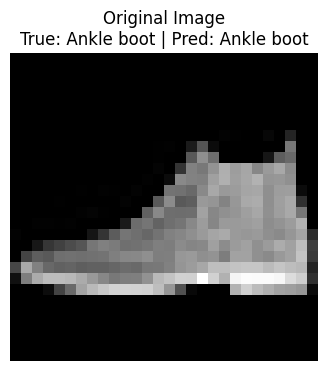

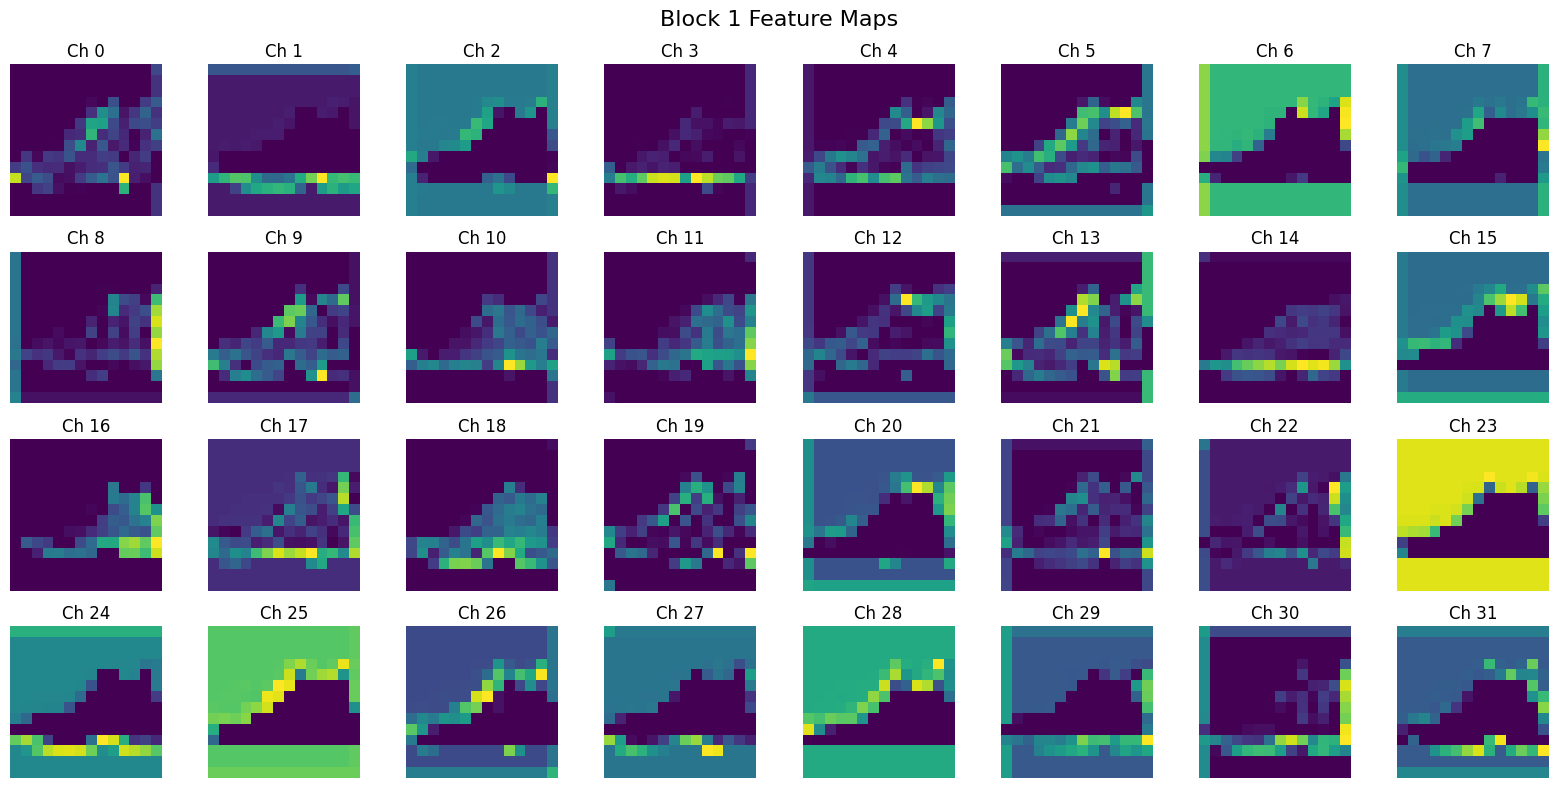

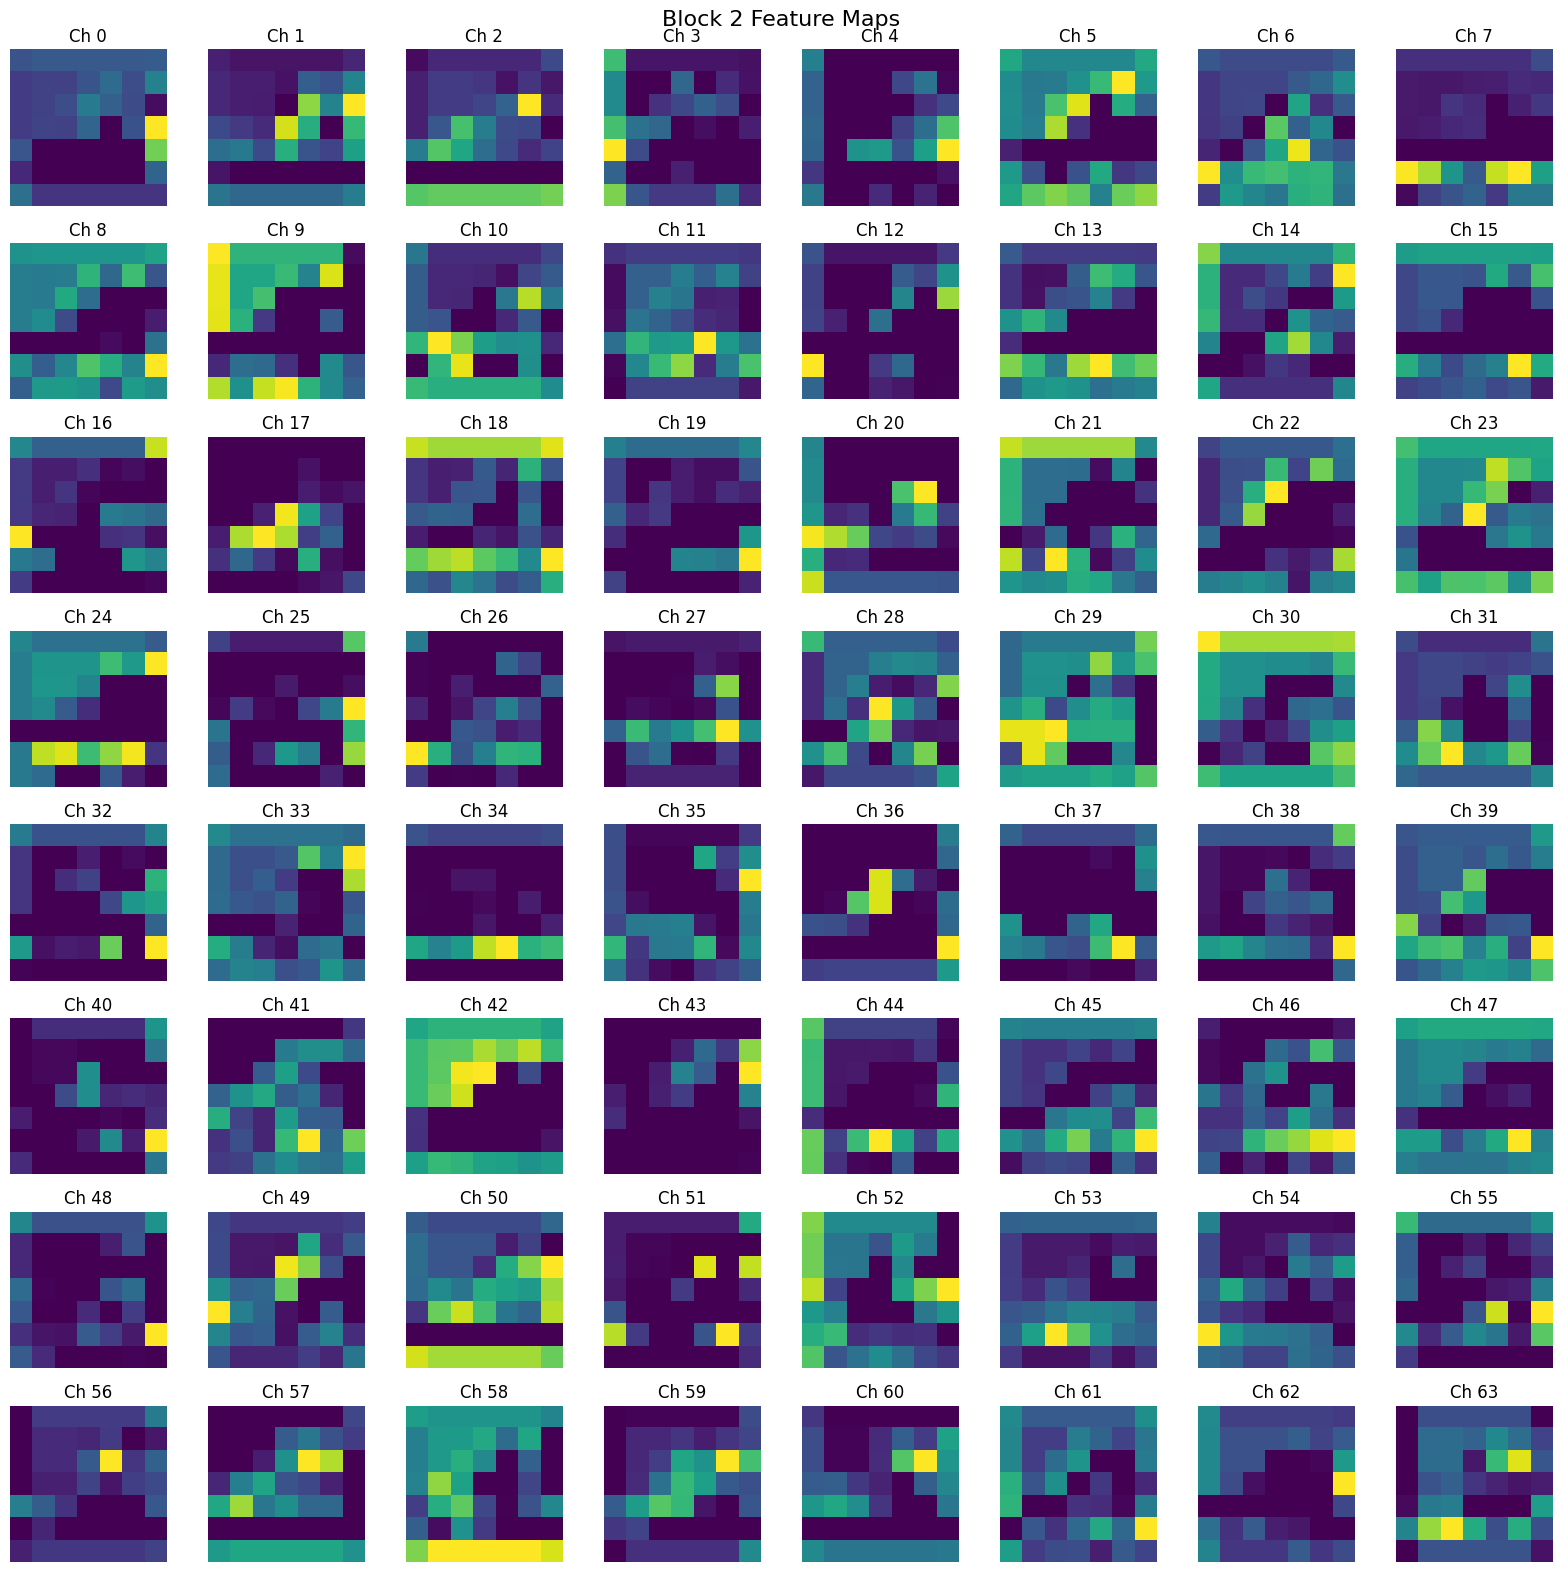

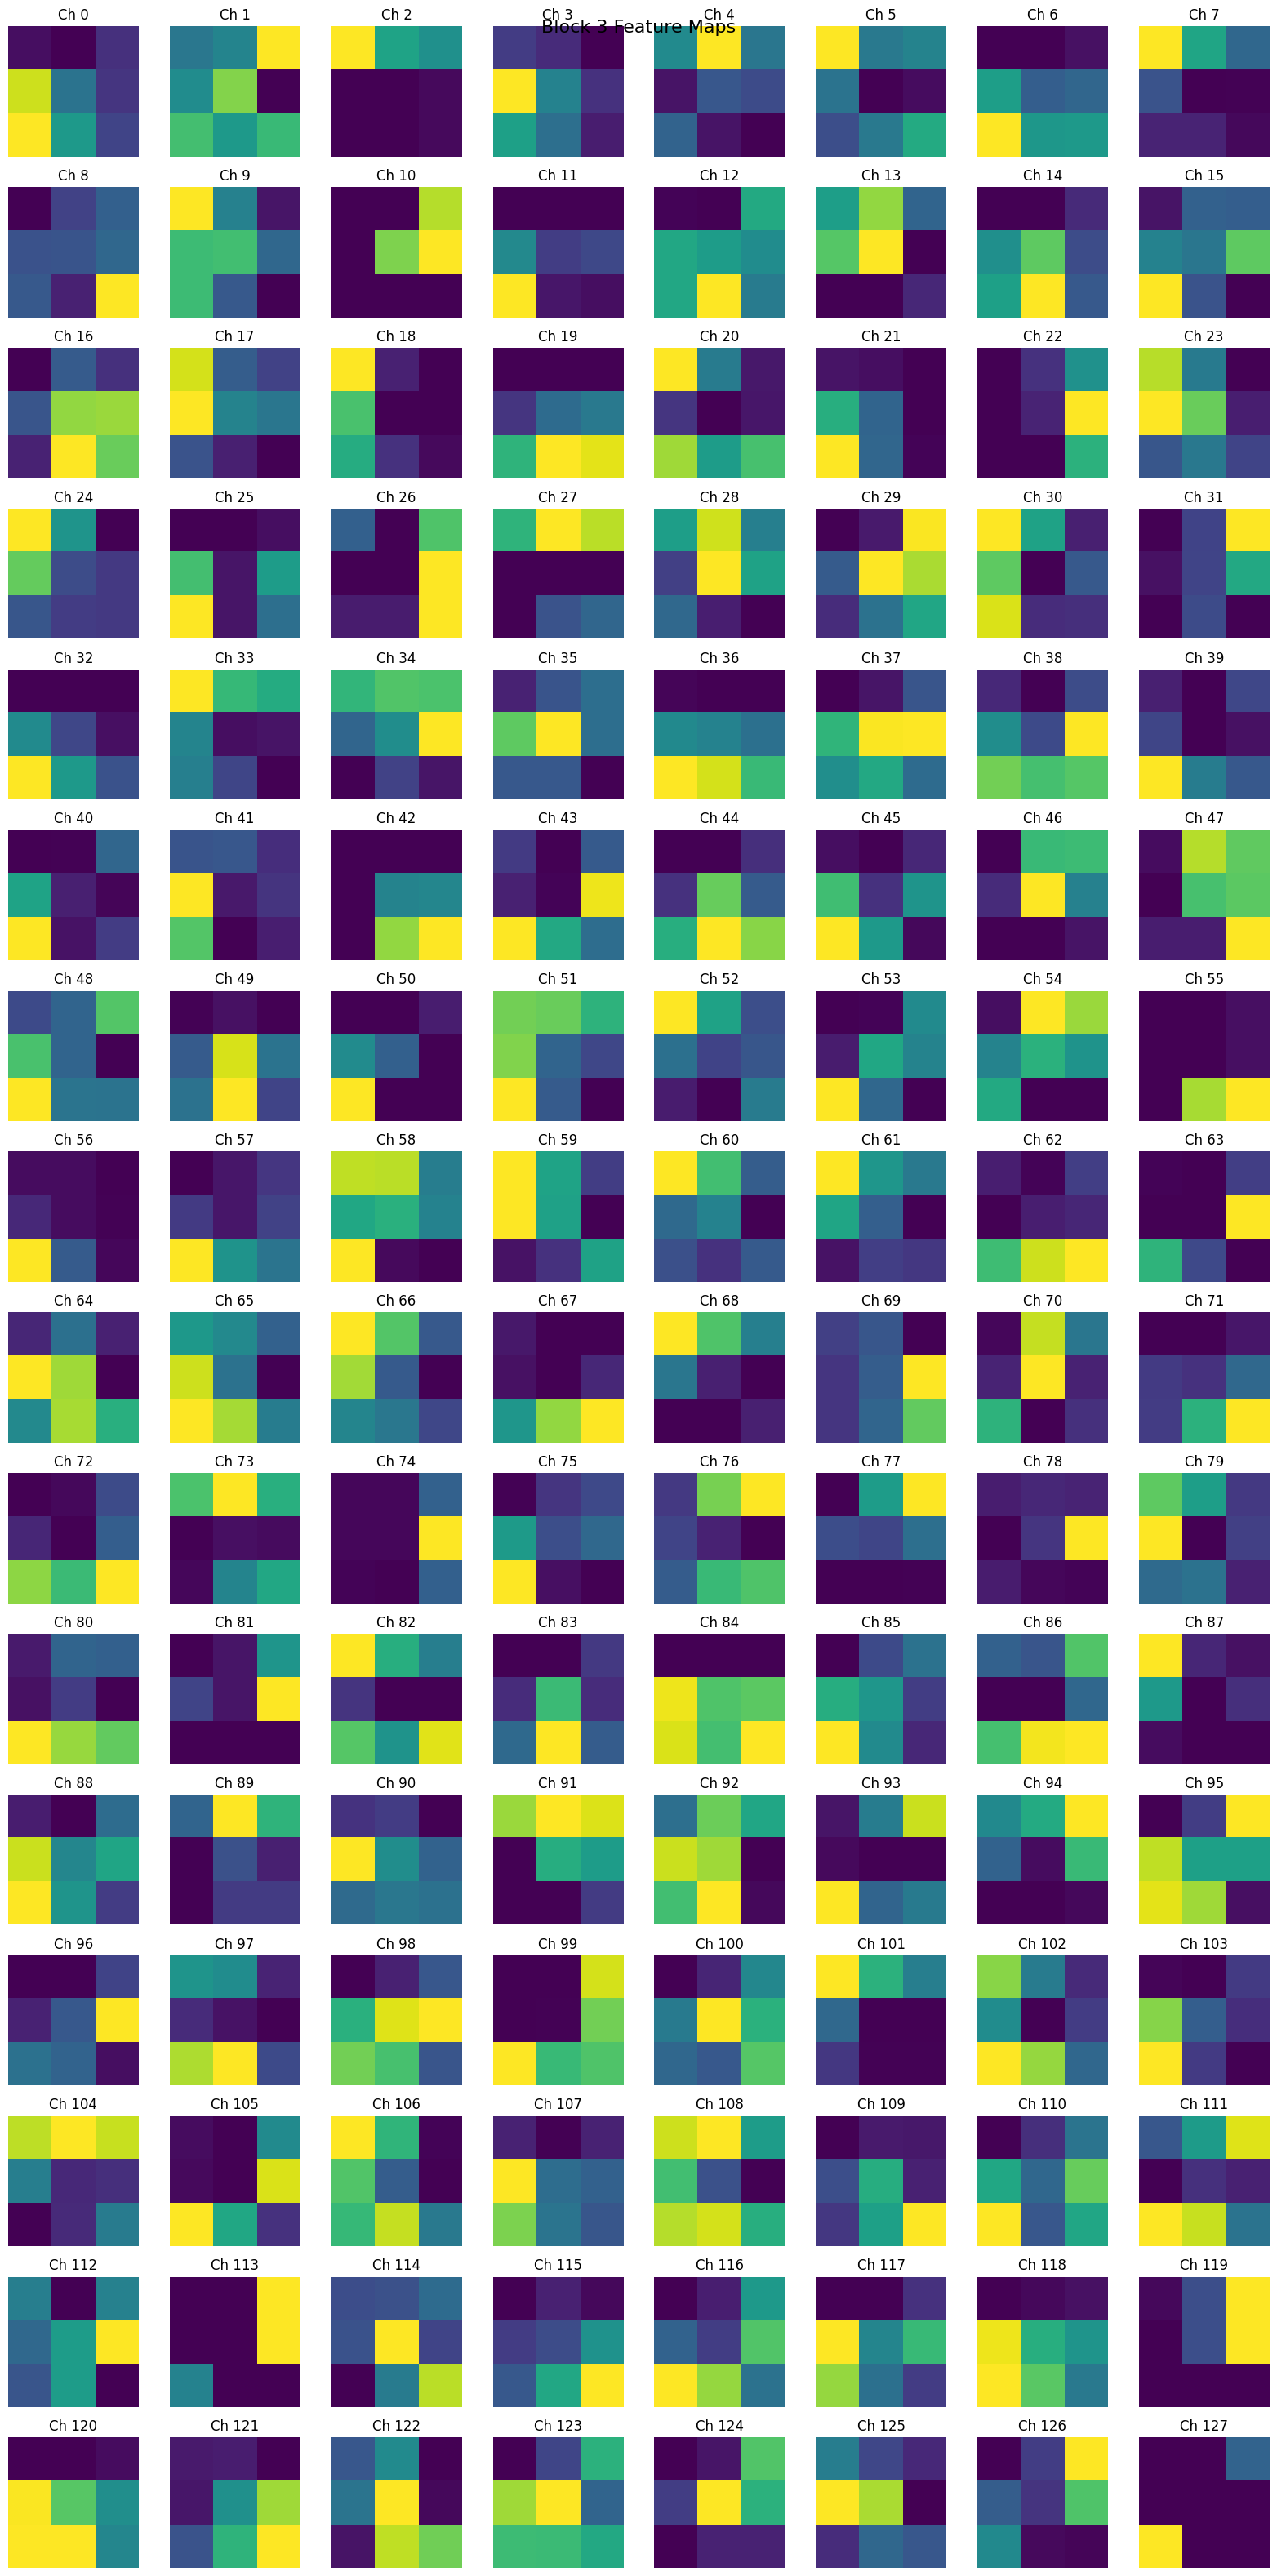

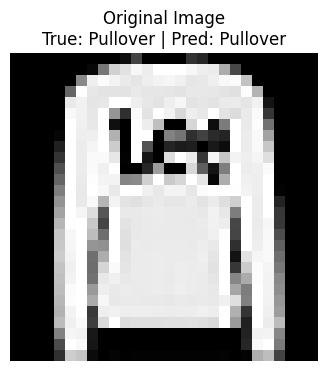

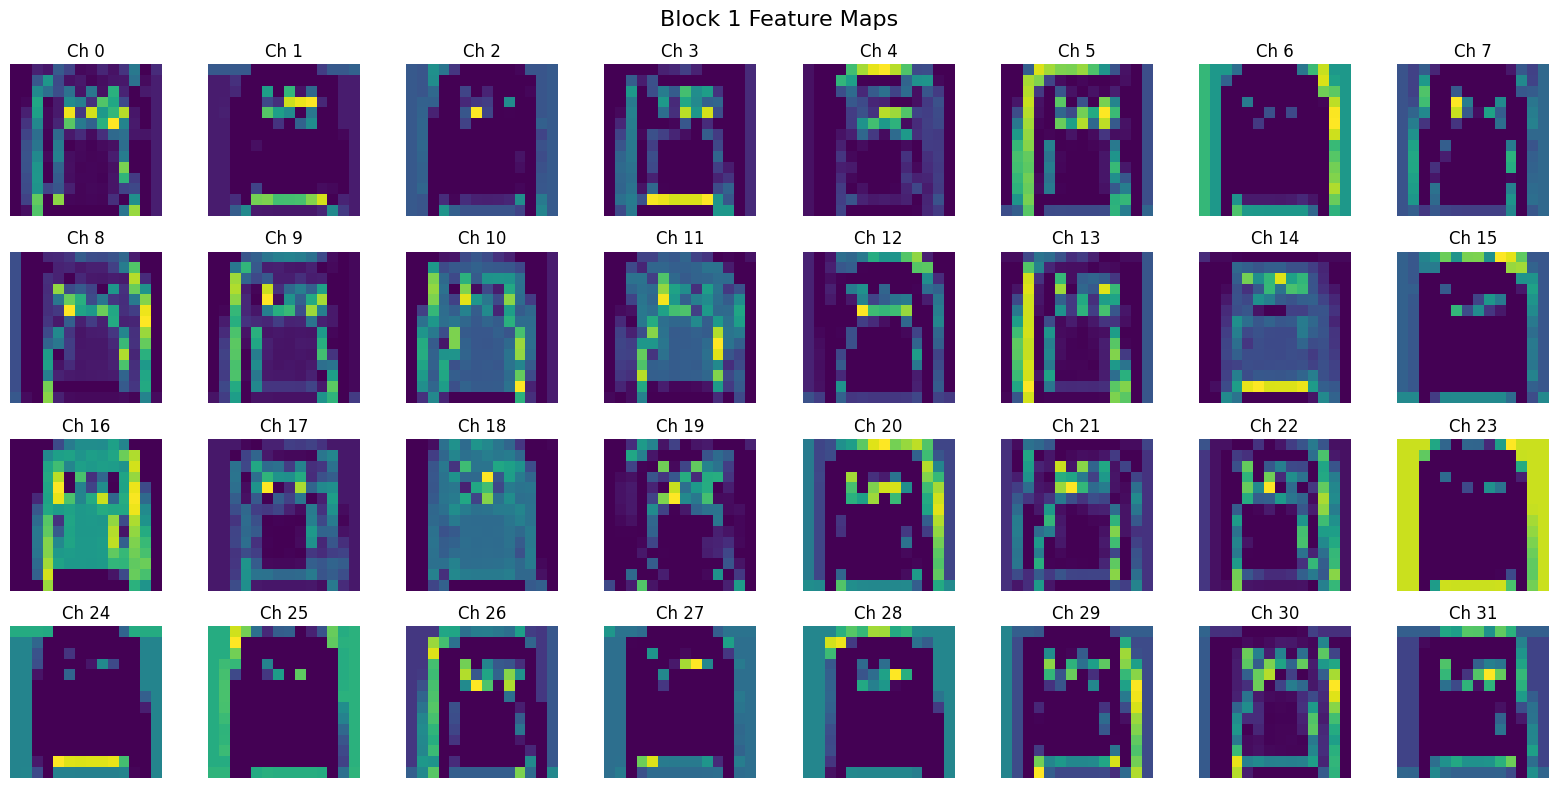

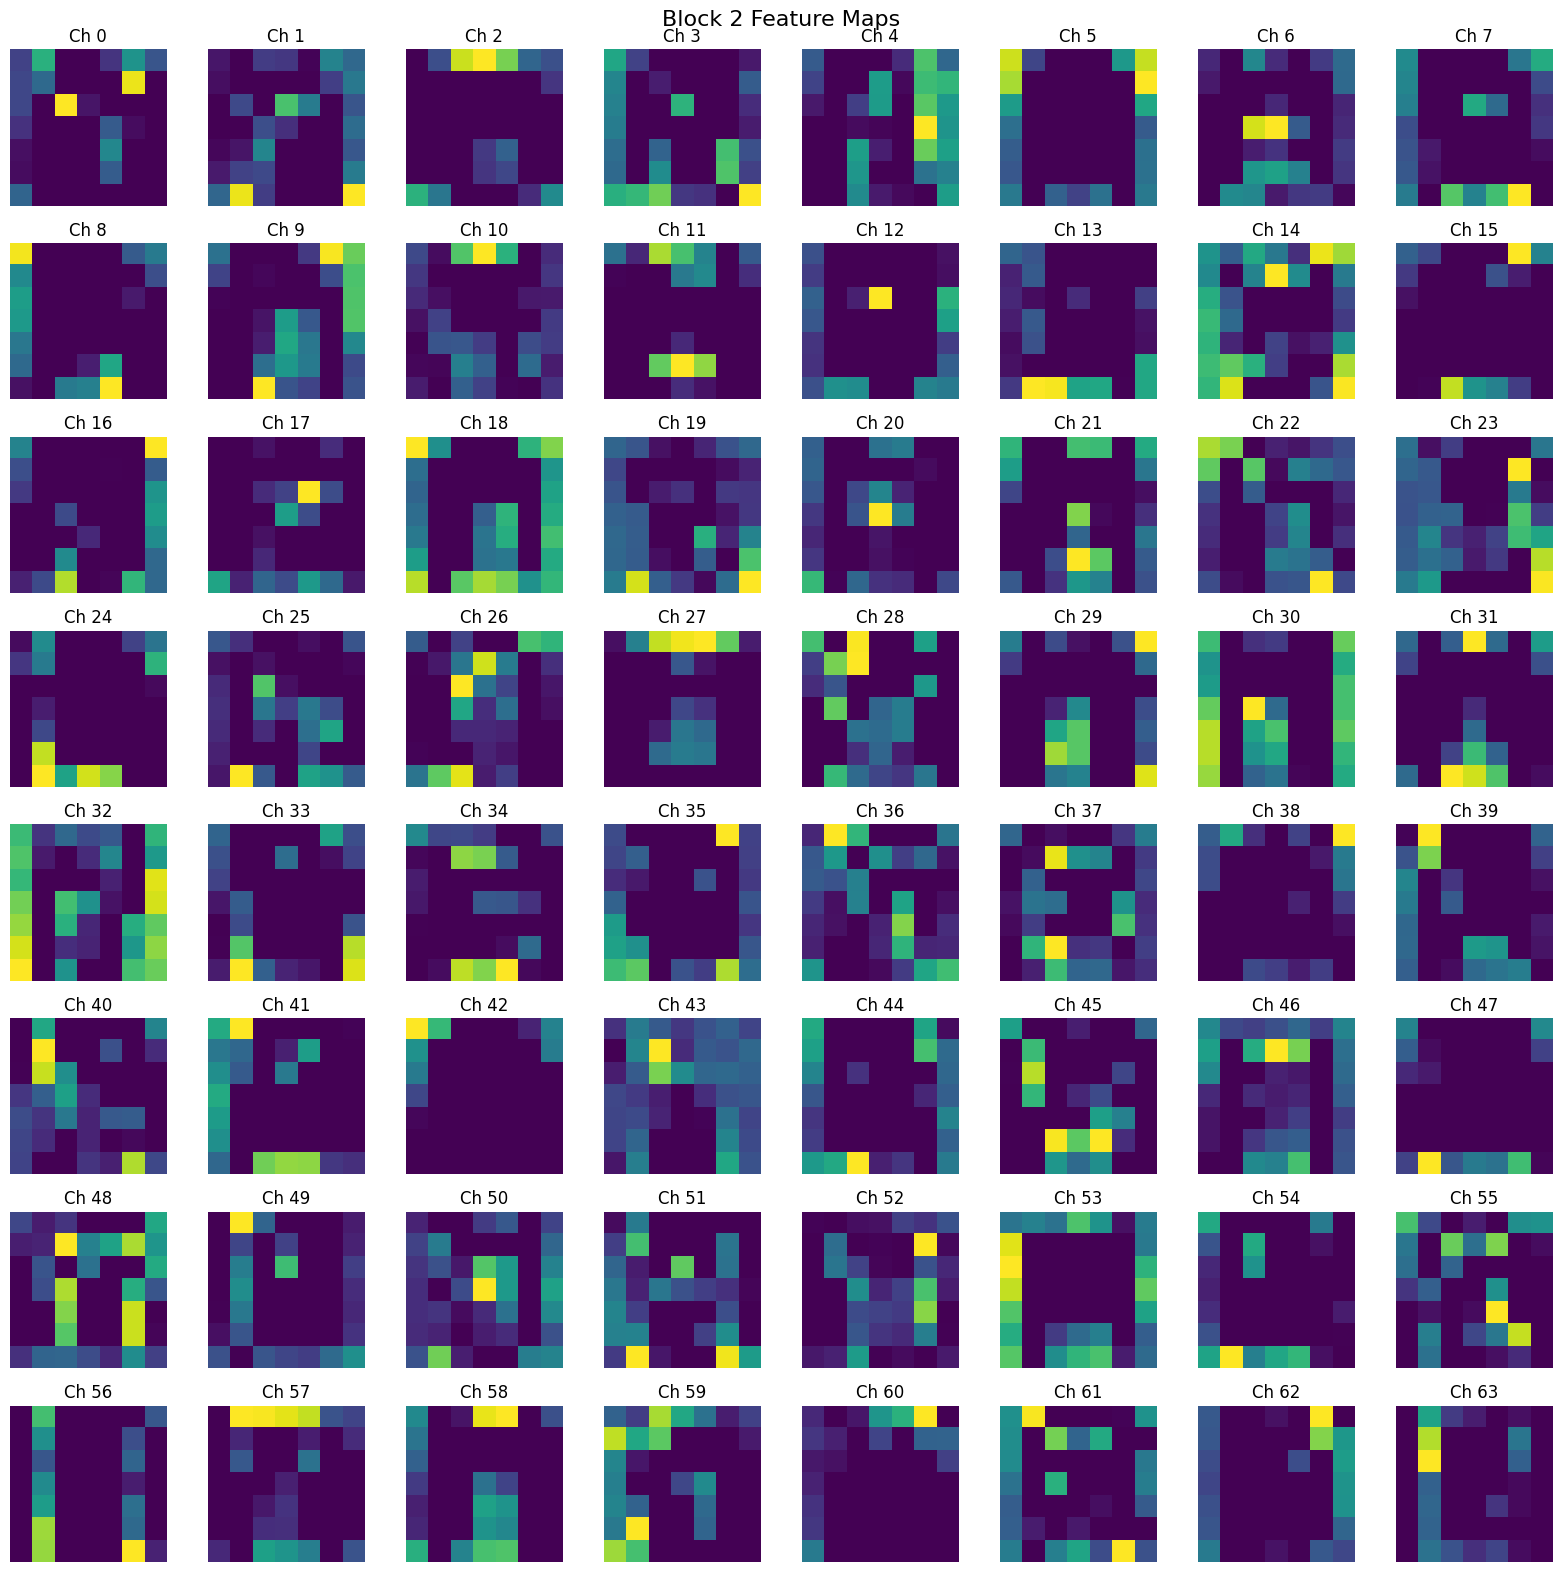

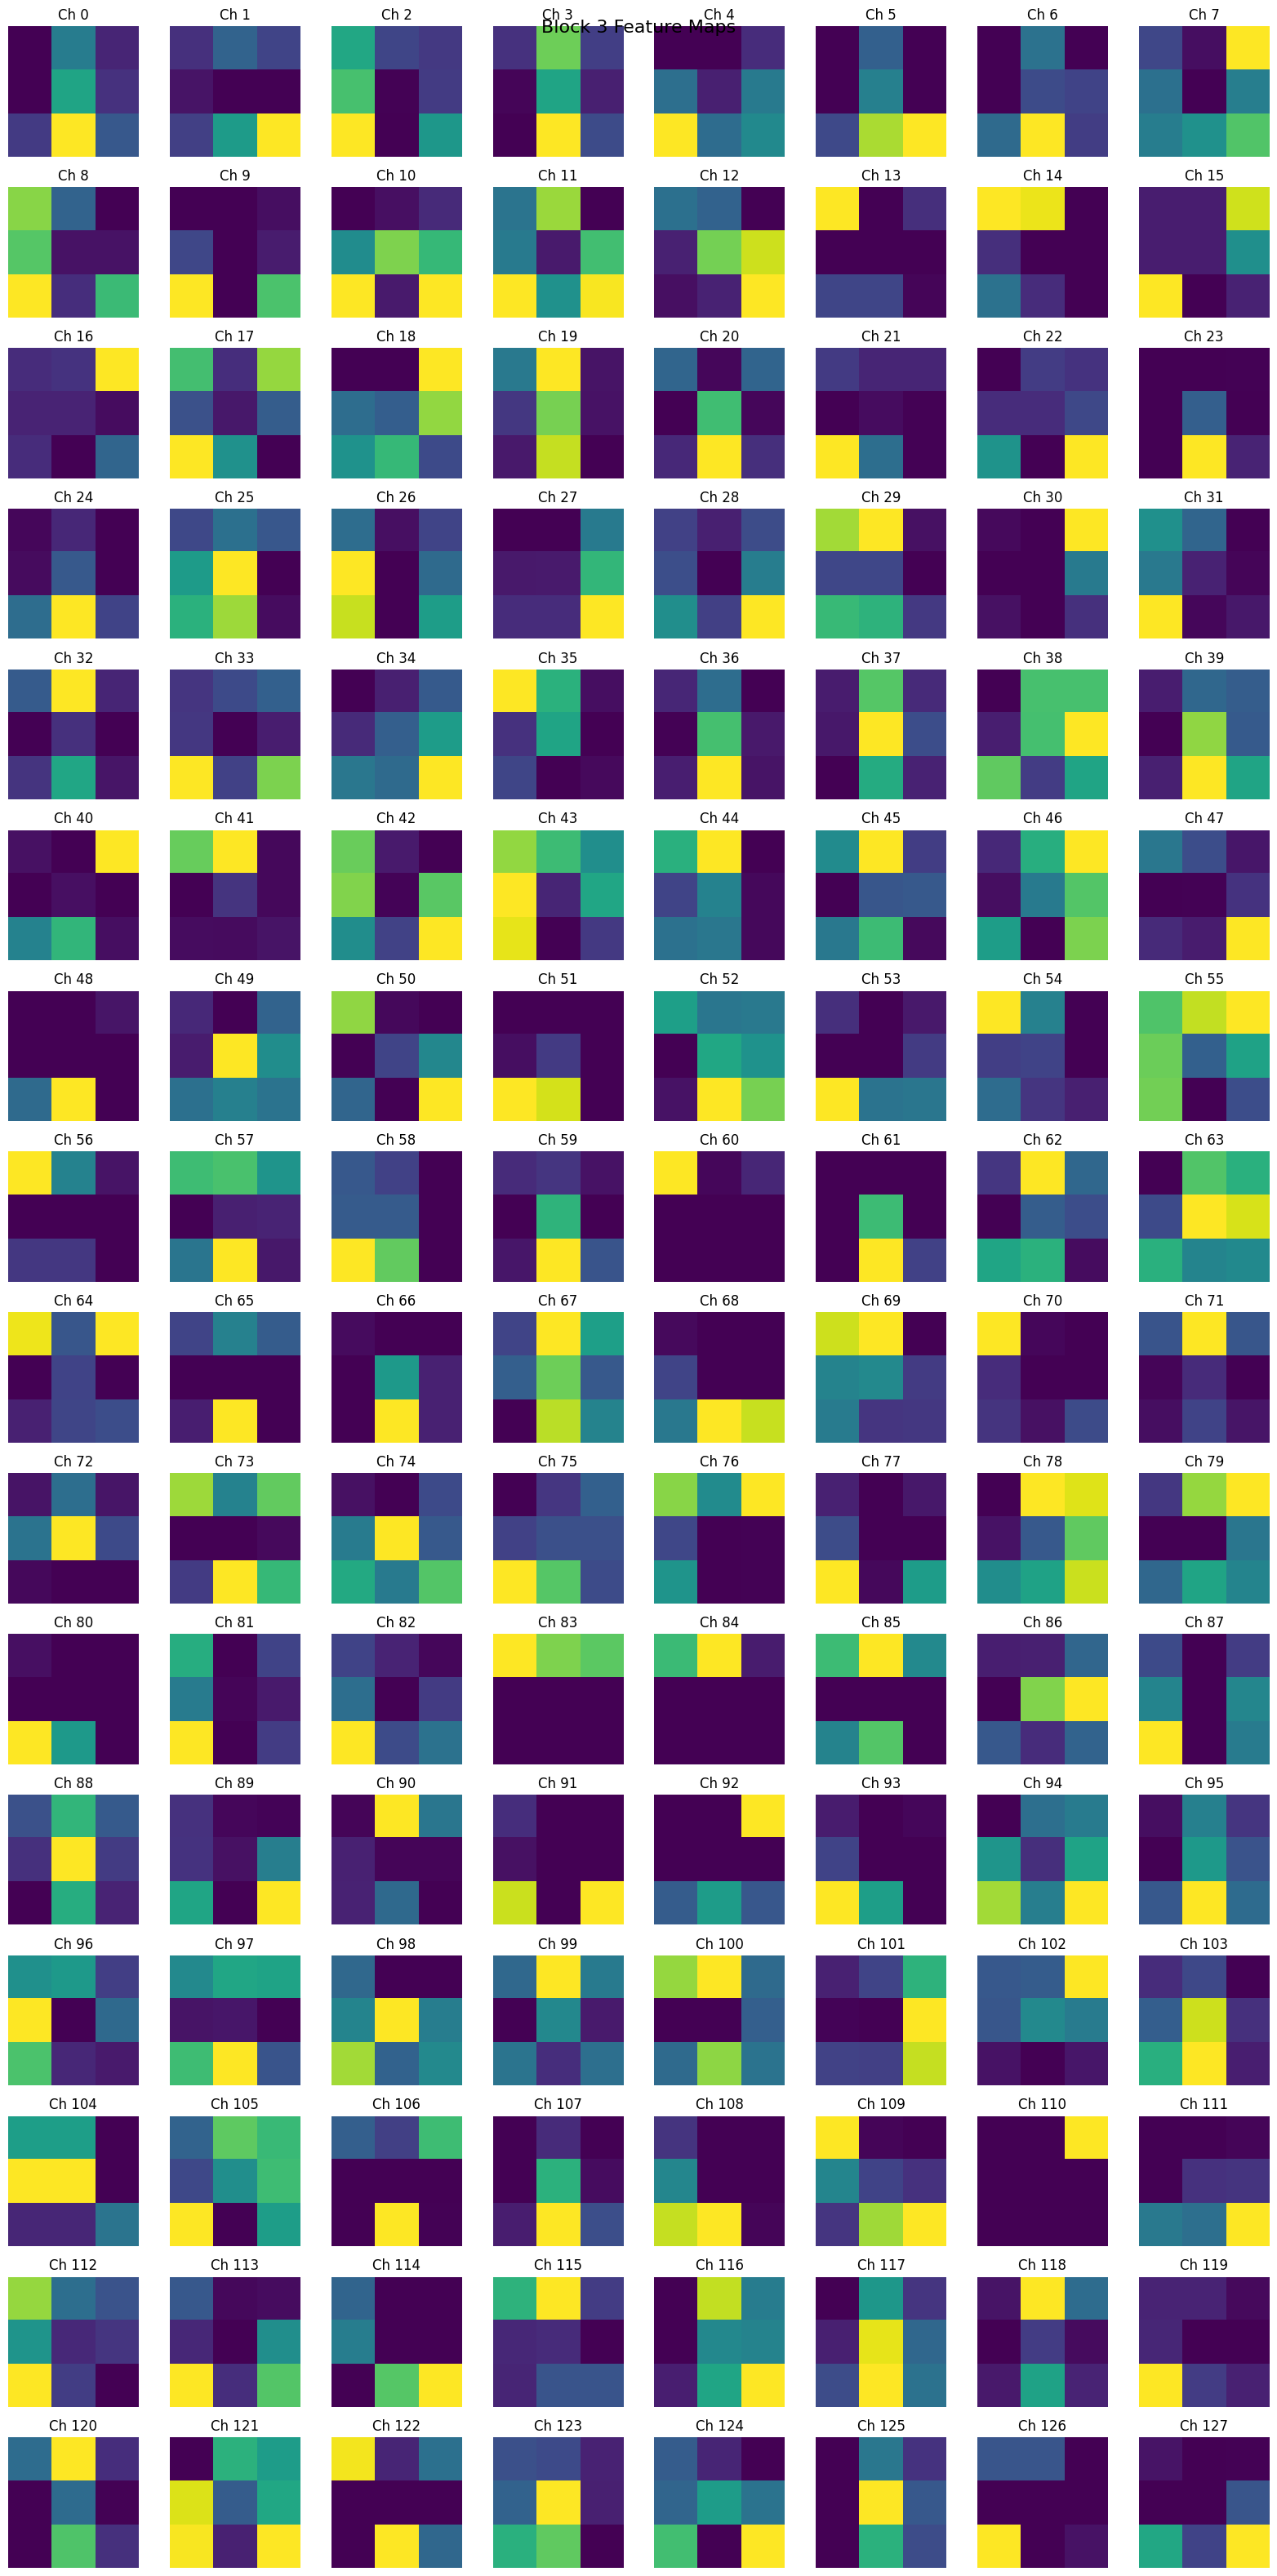

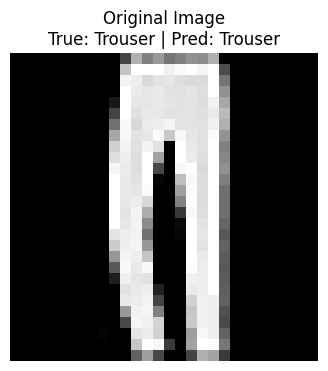

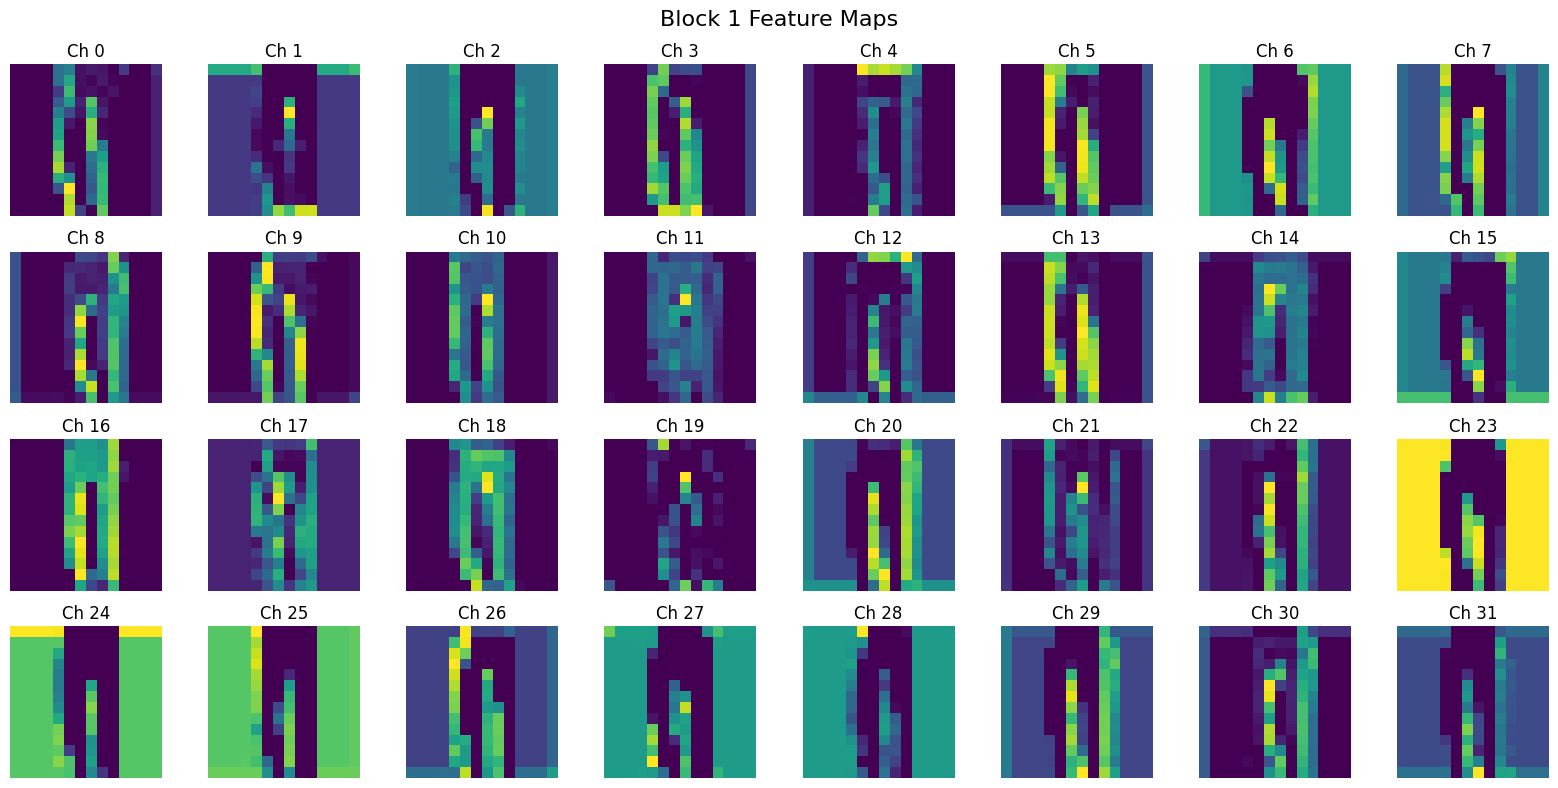

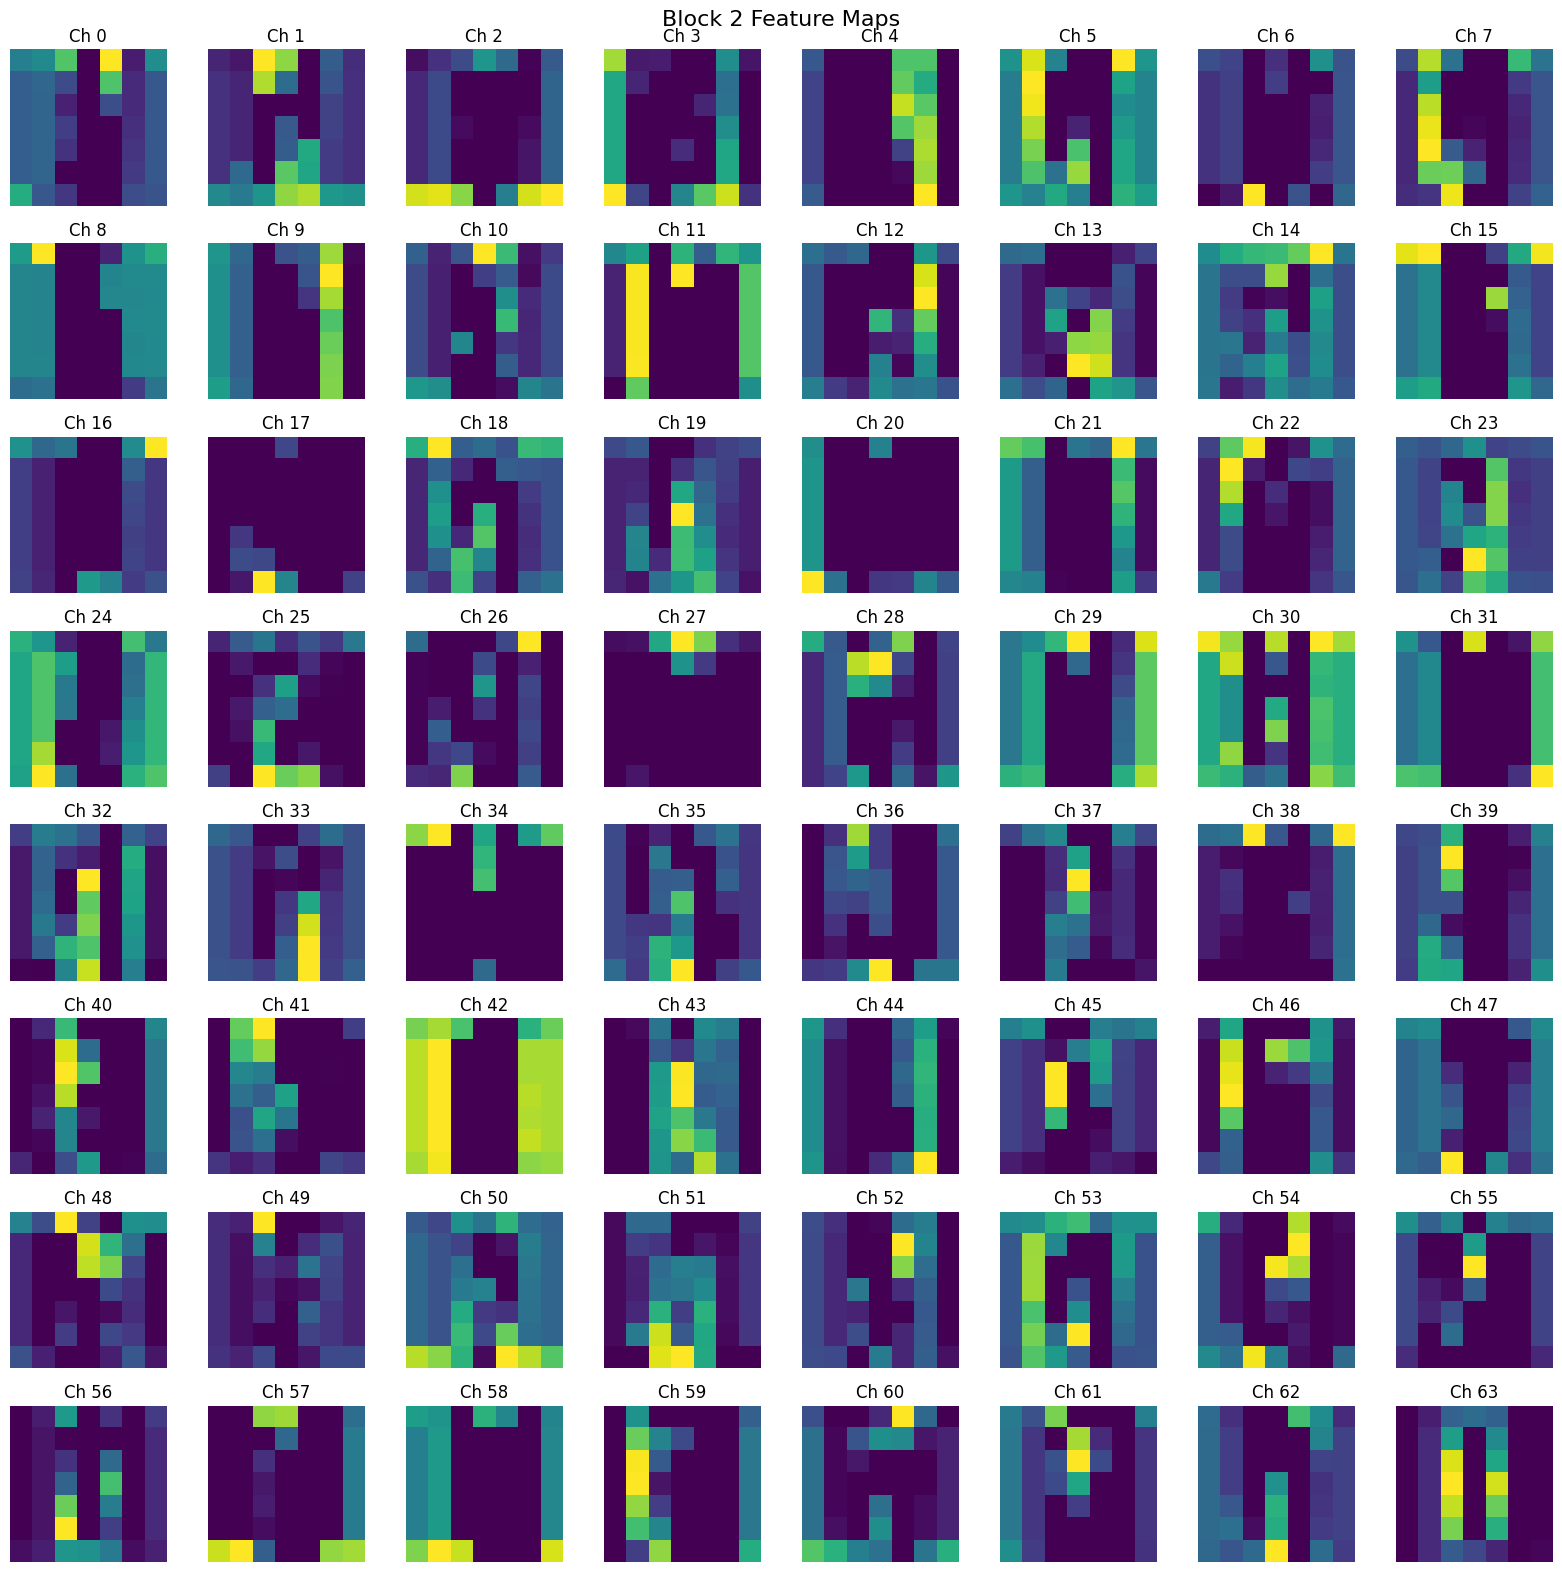

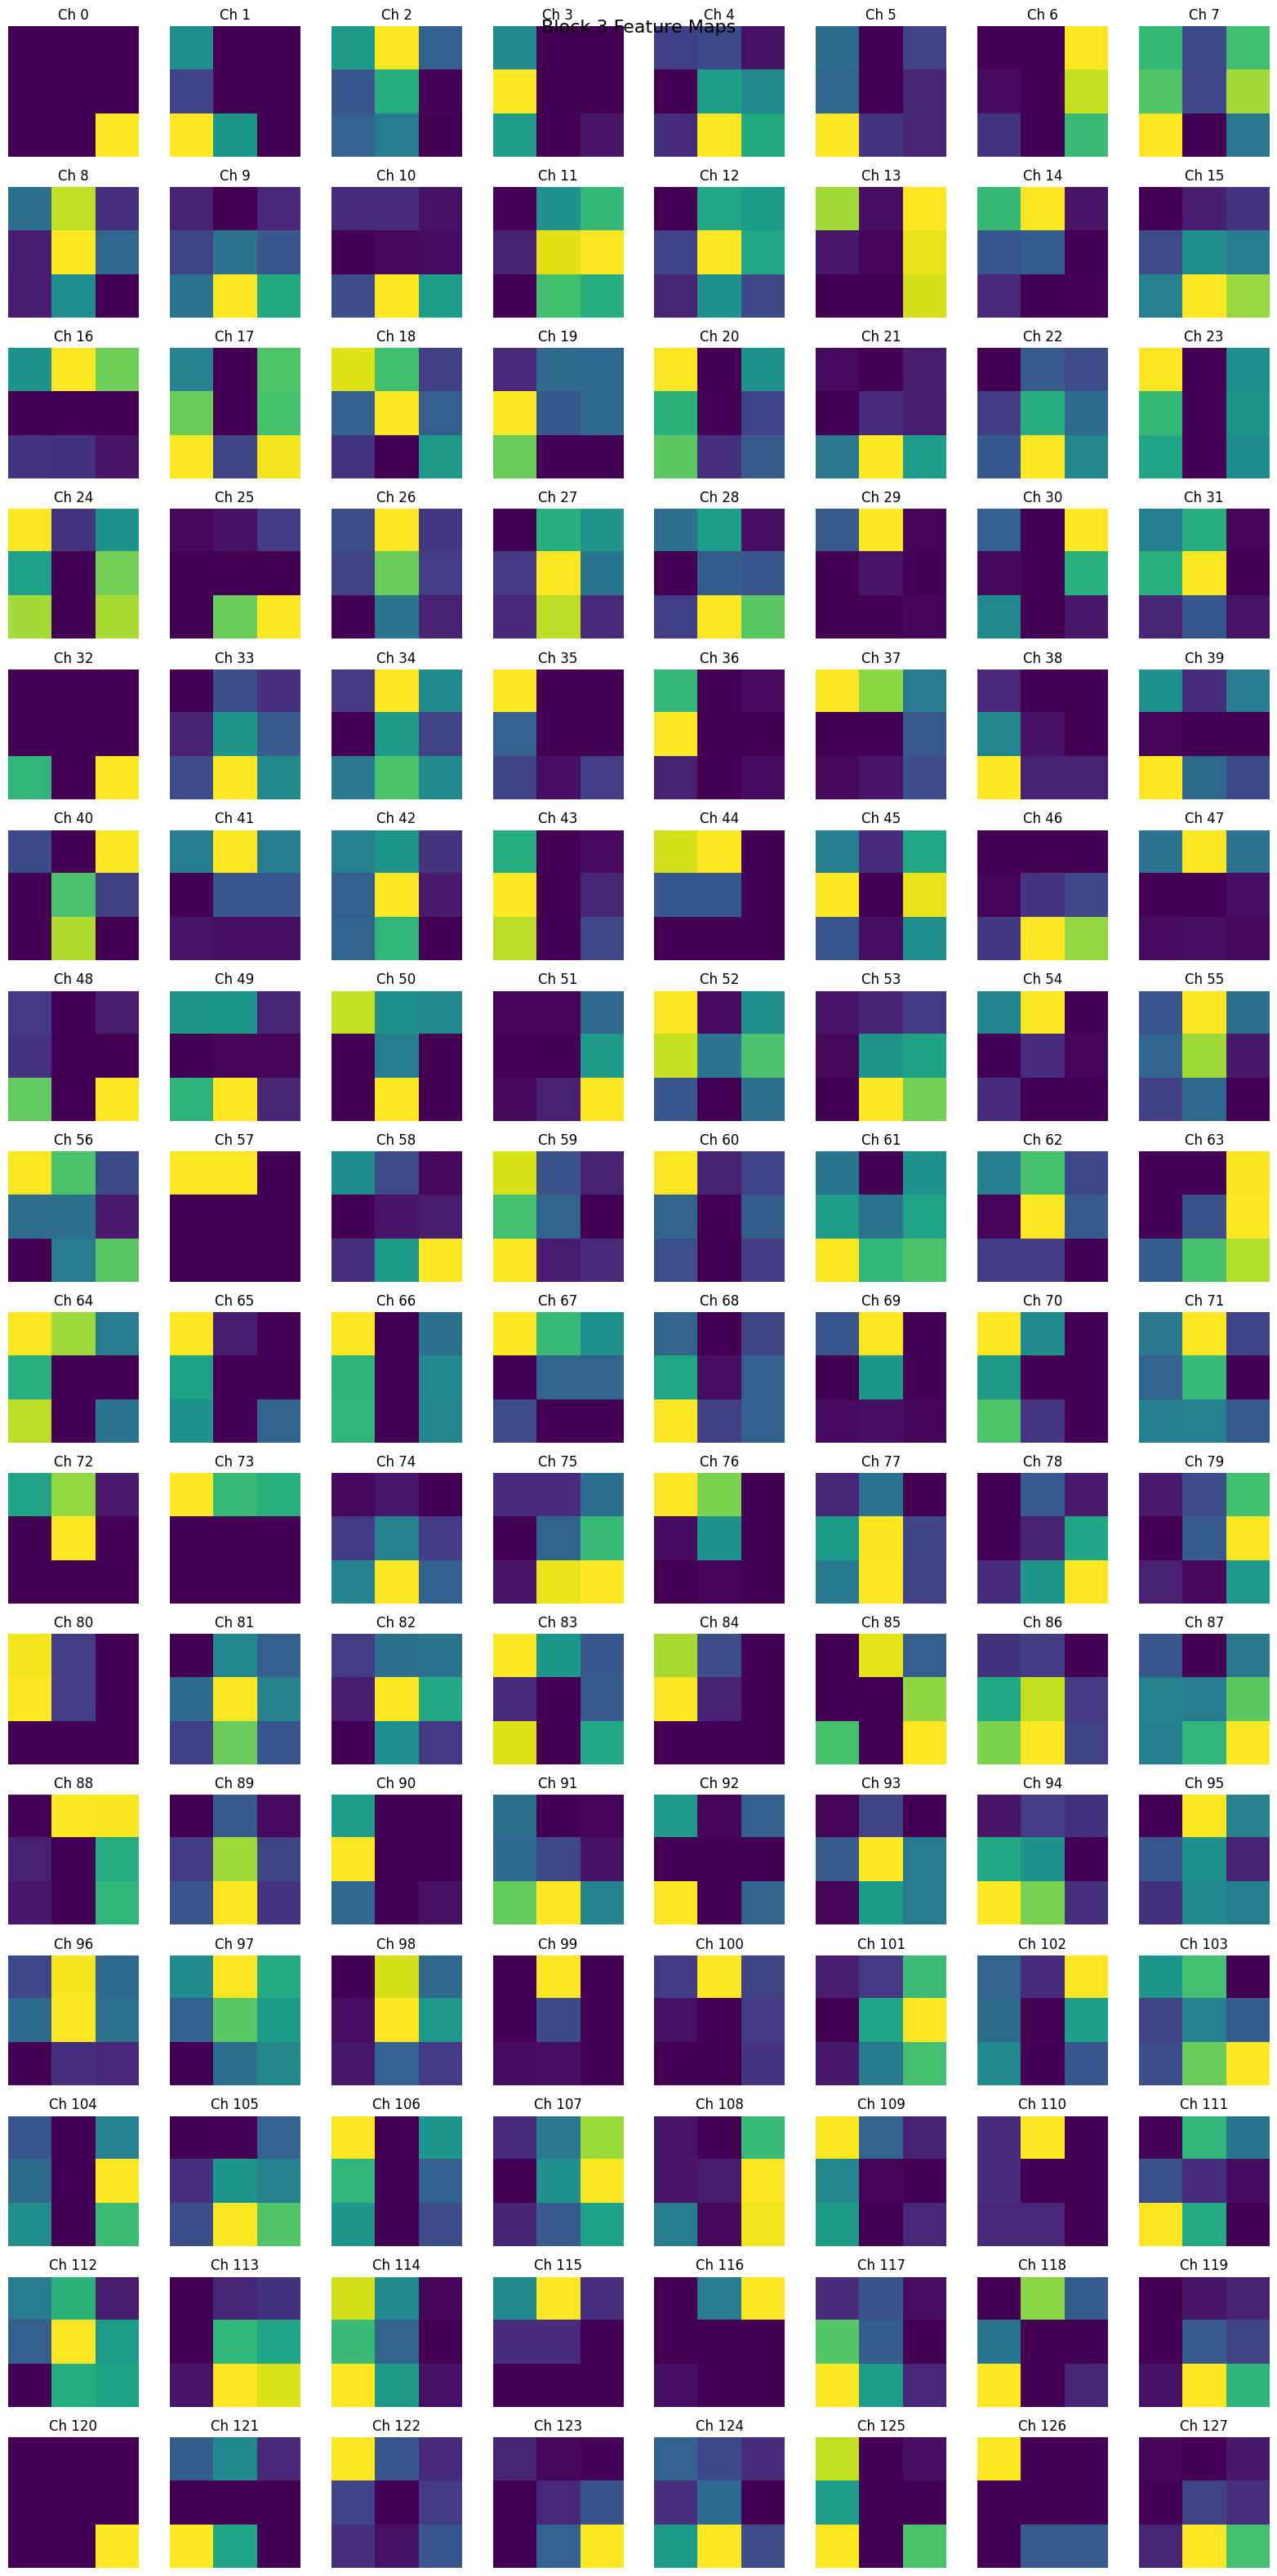

In [9]:
visualize_assignment_feature_maps(model, test_loader, device, num_images=3)

### Interpretation of Feature Maps

So what we can see is here the first layer which is generated from 28x28 to 14x14 layers pass through 32 filters and the filters each generate image from the input image and we can see each filter is learning the shape of the objects trying to detect the edges lines and texture in the image. Also in the boot case some filters have demacrated the sole and the rest of the body very differently that is because the filter is demacrating them heavily due to the contrast in the image.
So these 32 features try to demacrate based on the intensity and texture of the image.

(eg - channel 24 has marked the sole and the rest of the body very differently hence this channel has learnt about that the boot object has a sole and its work is to detect the sole.)


Now in the second layer where we have 32 input channels and 64 filter resulting in 64 images each image being generated by running each filter on all the 32 input channel and then summing up to get output. The size is now 7x7 and we see it is very different from the input image and on the first shot it feels there is no relation between the original image and the feature maps generated over here. Layer 1 was learning about edges,lines here what I feel is the corner learning the edge intersection points are being detected and being marked differently from those points where we do not find any intersections.

(eg - channel 29 has marked the area around the toes where the intersection between a straight sole line occurs with the curved body and that region is marked differnly implying that this filter will learn about the ankle part in case of boots.)

Now the third layer made from 64 input channels and 128 filters resulting in 128 output channels of size 3x3. Here it seems that there is no relation left with the original image and the feature maps are very abstract in nature. But since it learns about big regions in image so it learns about the different big regions in the image and marks them differently. In case of boot example it will try to mark the sole region the boot region and ankle region differently.

A way to compare this is check channel 120 of trouser and boot the 120th channel in trouser is same for all pixel except the right bottom corner where as in boot the lower left is of yellow color and rest are of some color means it learns where there is more intense features and marks accordingly.